In [1]:
from IPython.display import display
from matplotlib.lines import Line2D
import glob
import pandas as pd
import numpy as np3
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy import signal
%matplotlib inline 

## Data Exploration & Data Preprocessing

- Gain a basic understanding about the data format and structure.
- Initial visualization of the time series data for each machine.
- Identify the `normal`, `faulty`, and `failed` modes manually; Obtain a rough picture of the patterns for each mode.
- Spot the existence of the outliers and handle them properly.
- Visualize the preprocessed data.

### Data Basics

In [2]:
# import all the csv files and store them as a list of dataframes.
files = glob.glob("exampleco_data/*.csv")
dfs = [pd.read_csv(f,index_col = 0) for f in files]

In [3]:
# print the dimension of each dataframe
dfs[0].shape

(3000, 4)

In [4]:
# display the first five rows
dfs[0].head(5)

0         1          2          3
2019-01-01 00:00:00.000000000  12.626096  8.803120 -11.809200  10.083961
2019-01-01 08:00:09.603201067  10.831994  2.816327  11.554778  21.892853
2019-01-01 16:00:19.206402134  21.083510 -0.672645 -17.839178  -1.349024
2019-01-02 00:00:28.809603201  32.294495  6.525132 -13.498586  -4.250752
2019-01-02 08:00:38.412804268  28.057100  3.691359  21.984744  13.670561

In [5]:
dfs[0].describe()

0            1            2            3
count  3000.000000  3000.000000  3000.000000  3000.000000
mean     -0.816016    -1.091308     1.267945     0.165844
std      58.078319    55.965665    56.538700    56.910659
min    -323.954437  -258.780879  -287.153920  -365.362164
25%      -0.008684    -0.008851    -0.008274    -0.007883
50%      -0.000402    -0.000085     0.000669     0.000310
75%       0.007832     0.008373     0.009056     0.008685
max     315.738951   264.374782   281.684102   340.513819

In [6]:
# check for missing values
for i, df in enumerate(dfs):
    print( "Machine {}".format(i) + ' has {} missing values'.format(sum(df.isna().any())))

Machine 0 has 0 missing values
Machine 1 has 0 missing values
Machine 2 has 0 missing values
Machine 3 has 0 missing values
Machine 4 has 0 missing values
Machine 5 has 0 missing values
Machine 6 has 0 missing values
Machine 7 has 0 missing values
Machine 8 has 0 missing values
Machine 9 has 0 missing values
Machine 10 has 0 missing values
Machine 11 has 0 missing values
Machine 12 has 0 missing values
Machine 13 has 0 missing values
Machine 14 has 0 missing values
Machine 15 has 0 missing values
Machine 16 has 0 missing values
Machine 17 has 0 missing values
Machine 18 has 0 missing values
Machine 19 has 0 missing values


**Summary**:  
The dataset records four different time series for 20 machines. For each machine, the measurements were taken about every 8 hours. There are a total of 3000 measurements for each machine. No missing values are found for any measurements.

### Data Visualization

- Visualize the original series for each machine
- Remove the background noise and visualize the smoothed series. 
- Separate the four series for each machine for more insights

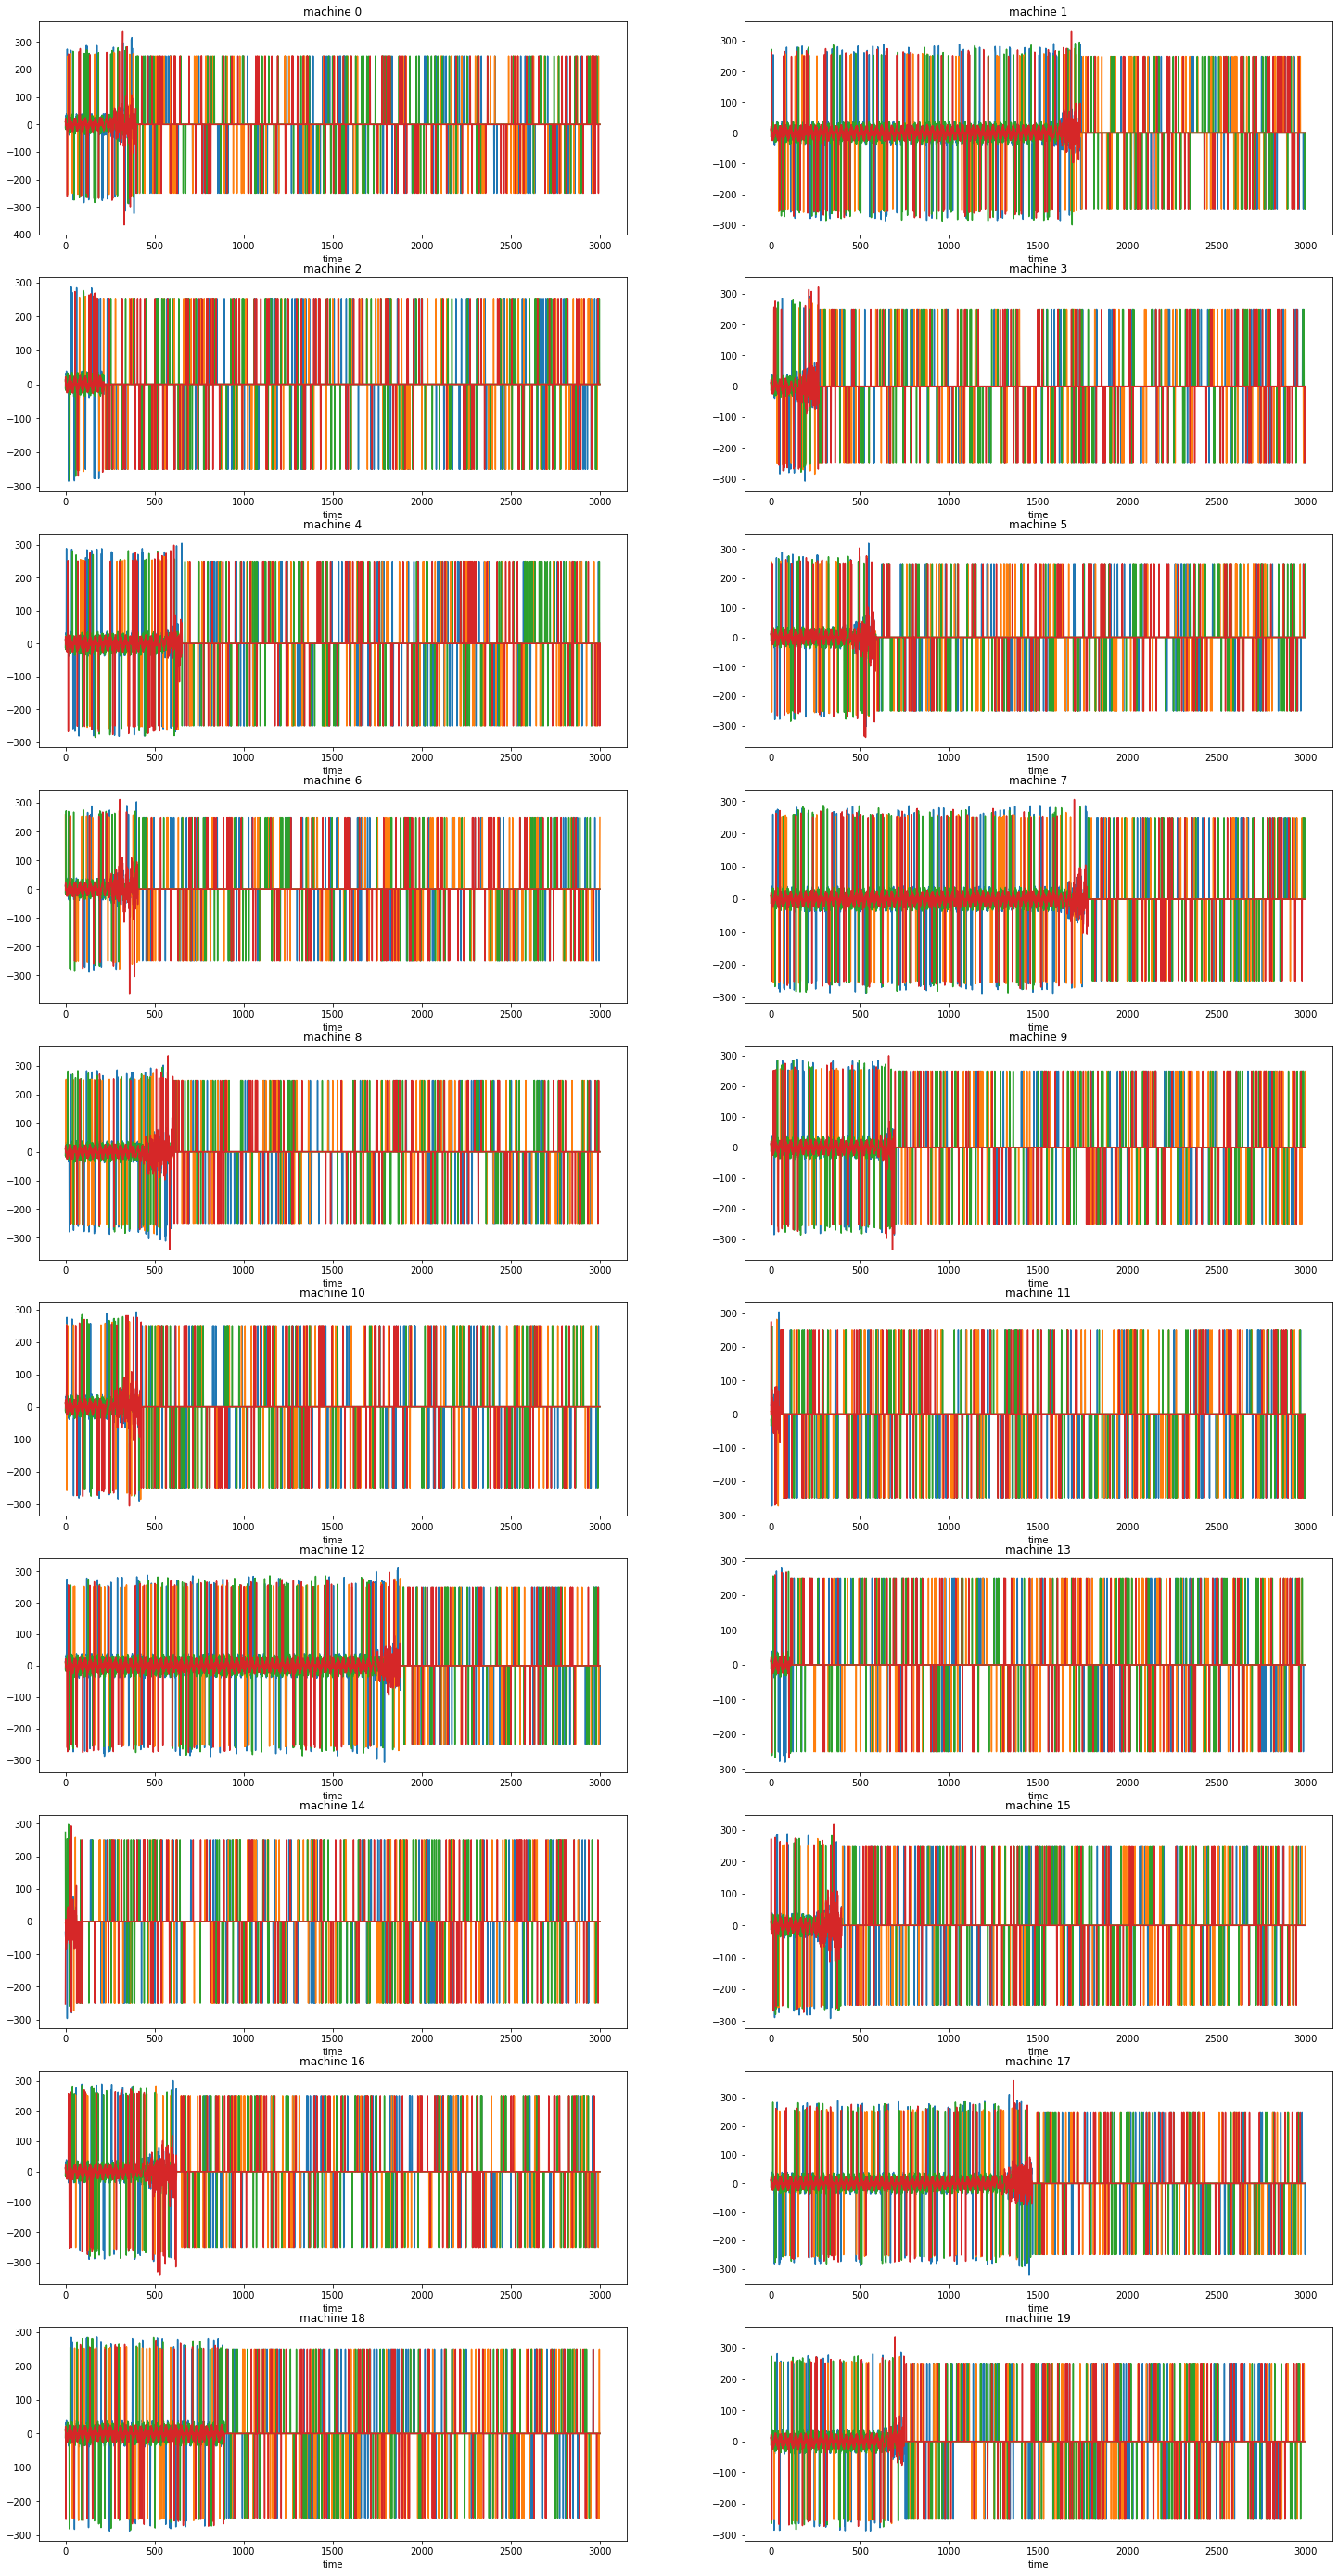

In [5]:
fig, axs = plt.subplots(10, 2, figsize=(25, 50))
for i, df in enumerate(dfs):
        axs[i//2, i%2].plot(range(df.shape[0]),df)
        axs[i//2, i%2].set_title('machine ' + str(i))
        axs[i//2, i%2].set_xlabel('time')
        

The signals have clear spikes when communication issues occur. To better observe the trends in the data, we need to first remove these spikes/outliers. 

Here, I plot the distributions of the signal values for machine 0. The plot shows the occurrence frequency for the signal values. From the plots, it seems that the outliers have magnitudes around 200 - 300 with low frequencies. 

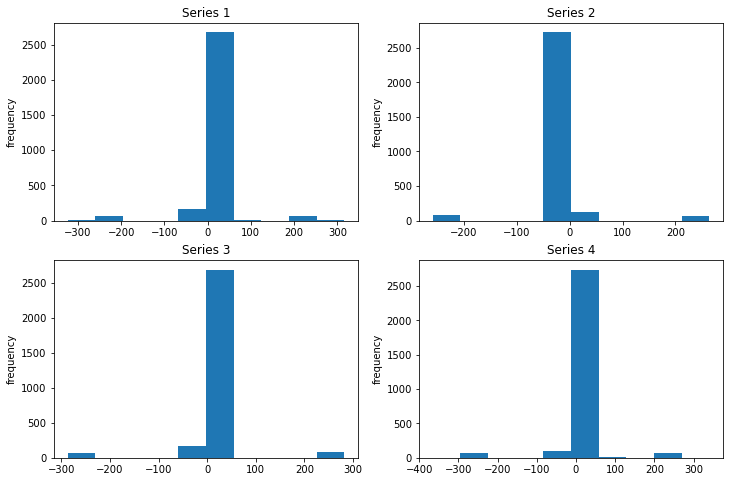

In [22]:
# check the distribution of the signals
plt.figure(figsize=(12,8))
for i in range(dfs[0].shape[1]):
    plt.subplot(2,2, i+1)
    plt.hist(dfs[0].iloc[:, i])
    plt.ylabel('frequency')
    plt.title('Series ' + str(int(dfs[0].columns[i])+ 1))

### Handling the Outliers 

The existence of the outliers will hinder spectral analysis and model training. Thus, handling the outliers is my first step. The frequency of the outliers is relatively low and the values are considerably different from the non-outliers. Here, I used a median filter with window size 5. The filtered data is imputed with the nearest point to preserve the shape of the signals.   


**Reference**:  [scipy.ndimage.median_filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.median_filter.html#scipy.ndimage.median_filter)


In [6]:
dfs_denoise = []

for df in dfs:
    dfs_denoise.append(pd.DataFrame(median_filter(df, size = 5, mode = 'nearest'), columns = ['ts1', 'ts2', 'ts3', 'ts4']))

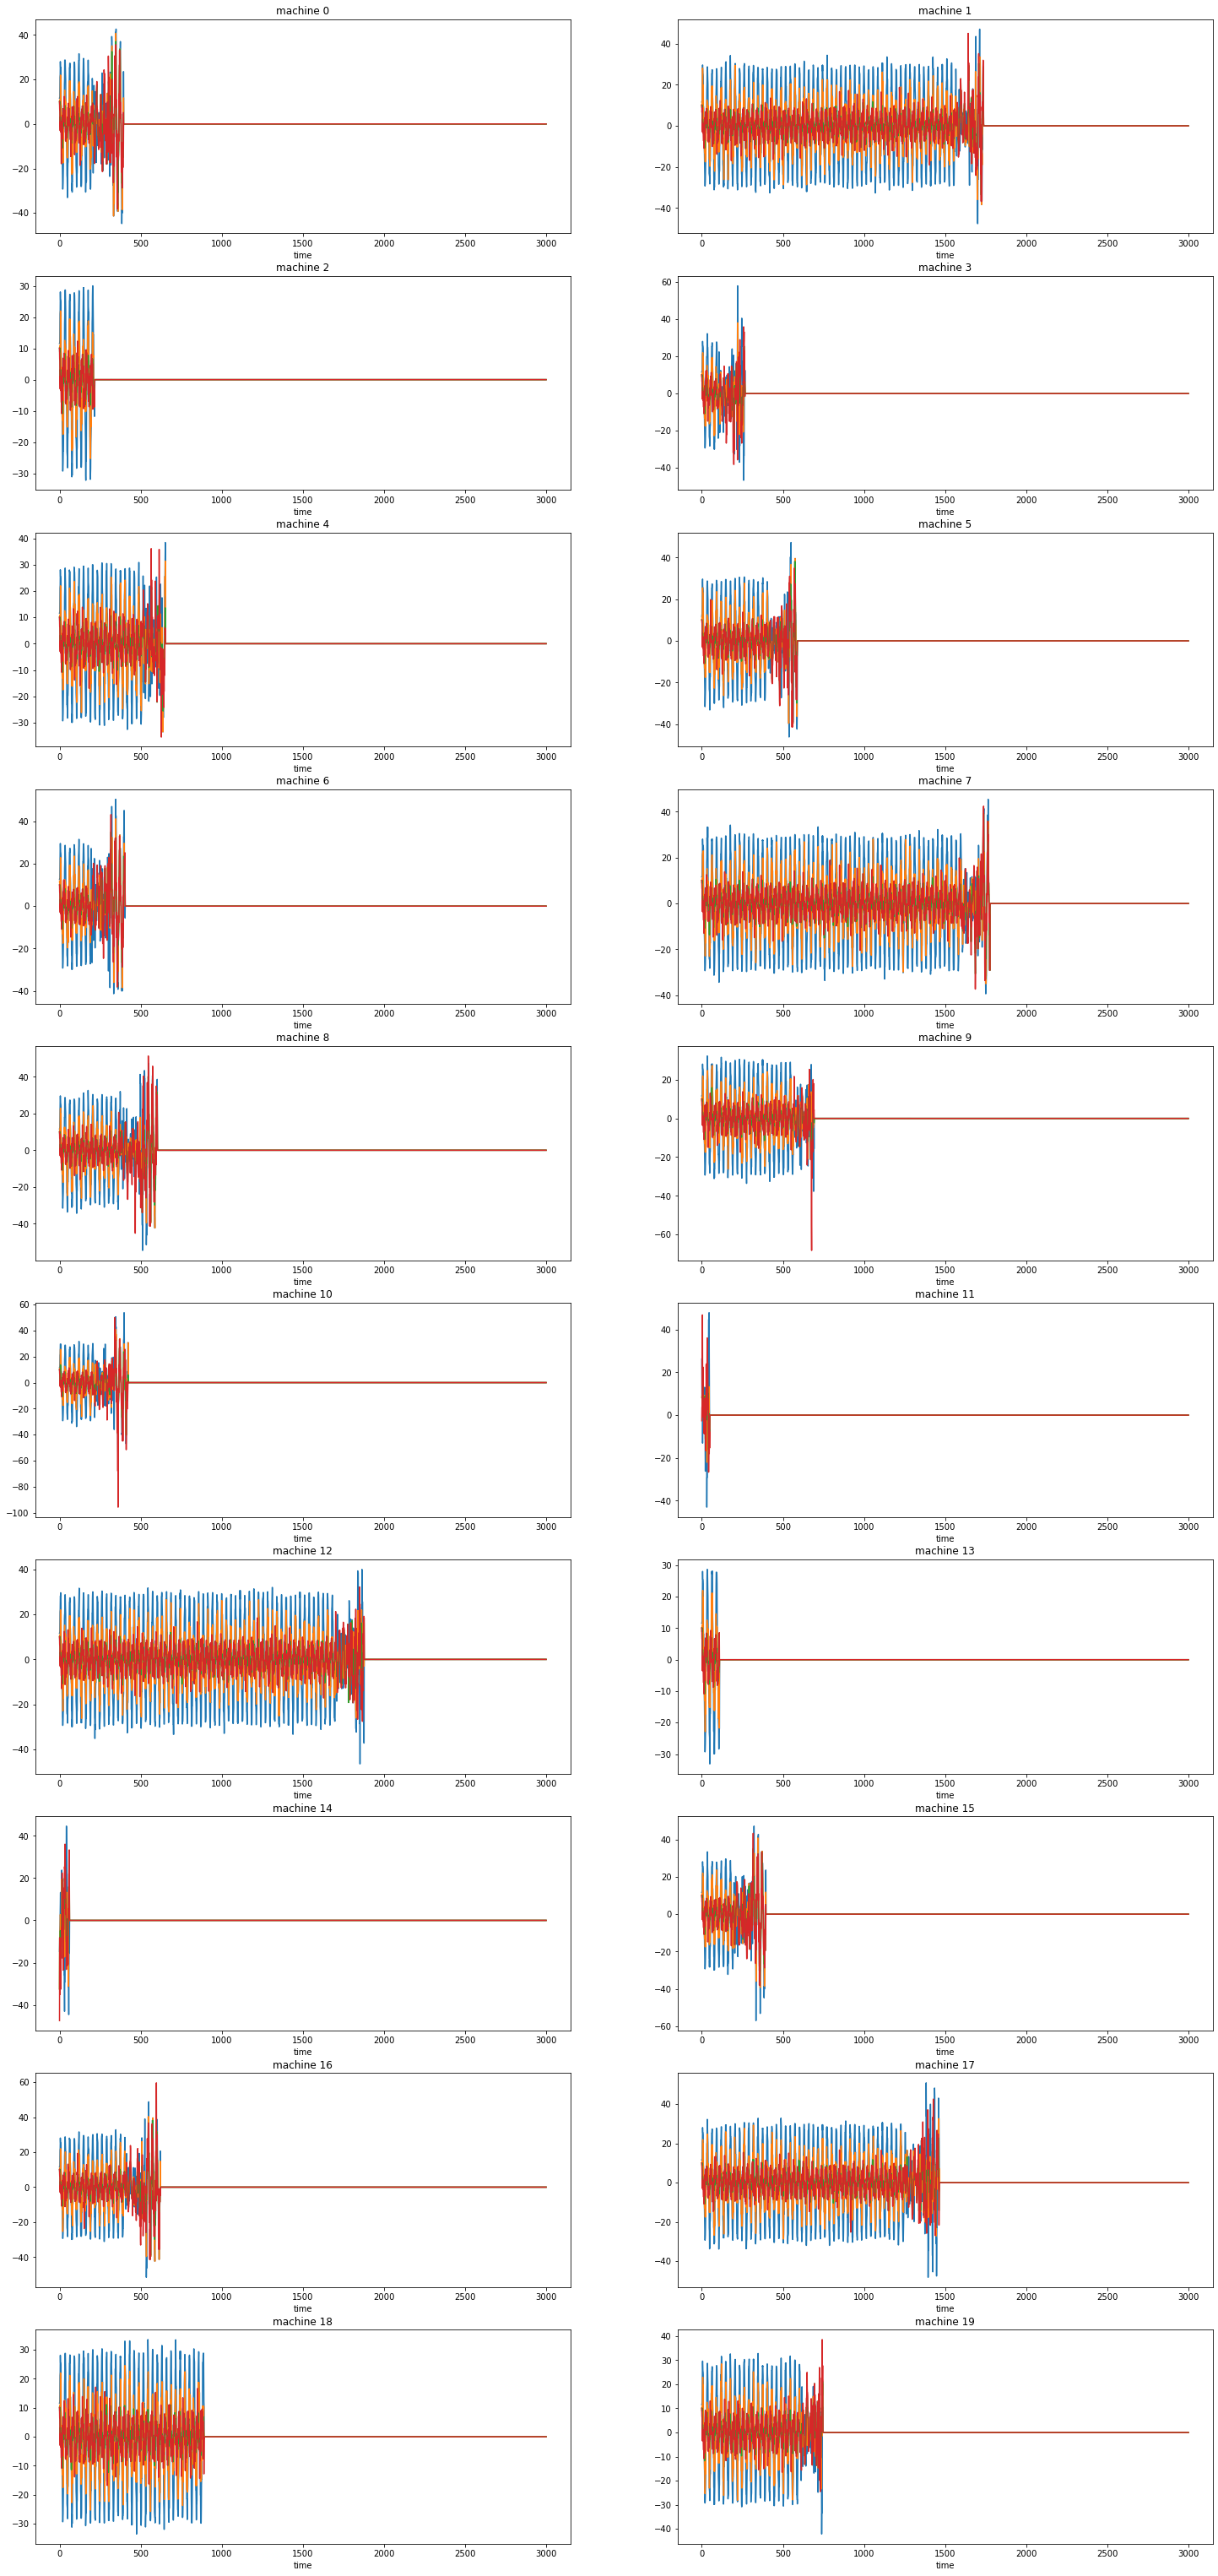

In [27]:
fig, axs = plt.subplots(10, 2, figsize=(25, 55))
for i, df in enumerate(dfs_denoise):
        axs[i//2, i%2].plot(range(df.shape[0]), df)
        axs[i//2, i%2].set_title('machine ' + str(i))
        axs[i//2, i%2].set_xlabel('time')
plt.show()

We can now clearly see different modes of each machine. At a glance, it seems that the signals oscillate with periodic patterns within bounded amplitudes when the machines are in the normal mode. Once the machines enter a faulty state, the signals show random fluctuations and may reach values outside the ranges of the normal states. The failed states are easy to spot, as the signals fall to around zero with little fluctuations.   

To zoom in to the normal mode and the faulty mode, I removed the fail states in the following plots and also separated the four series.

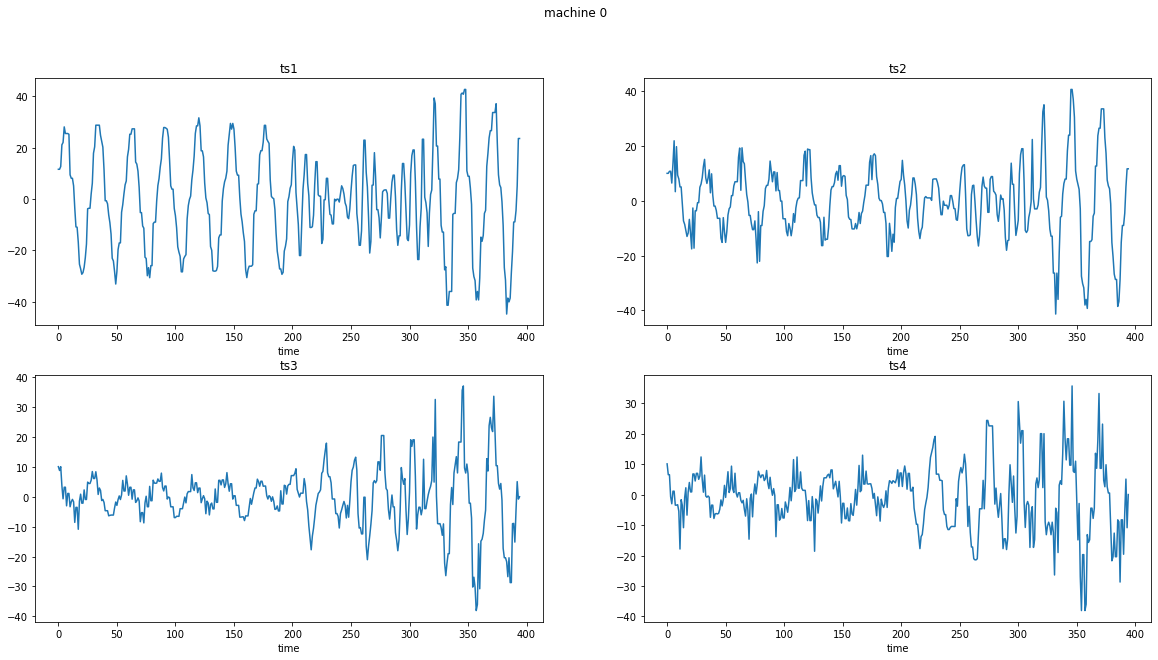

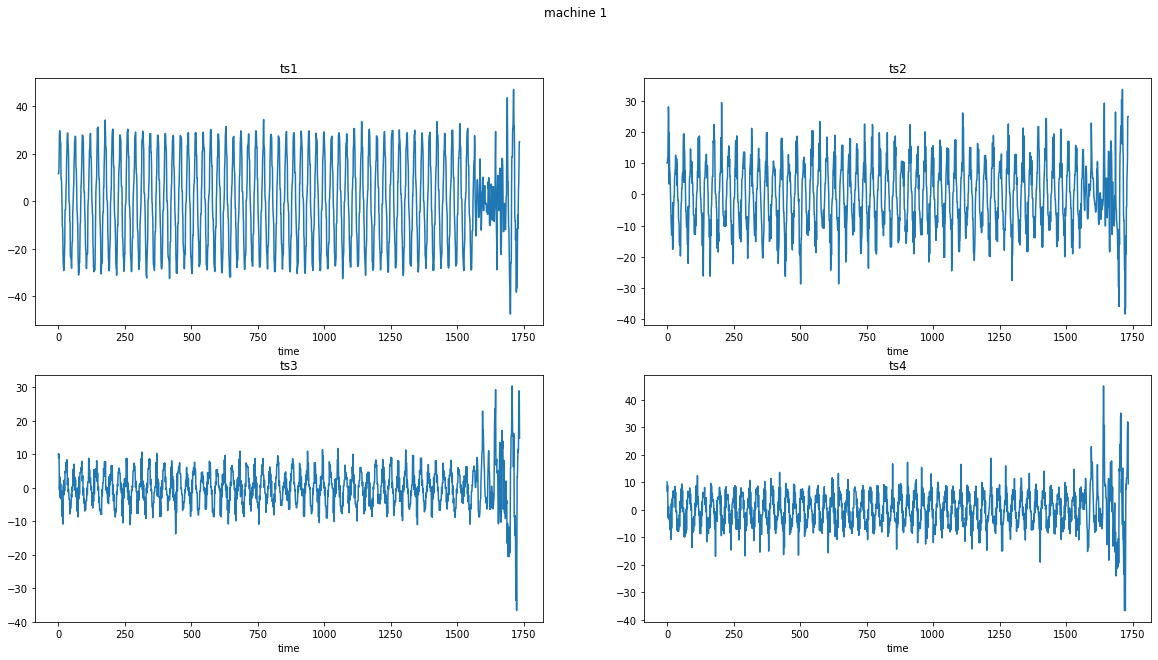

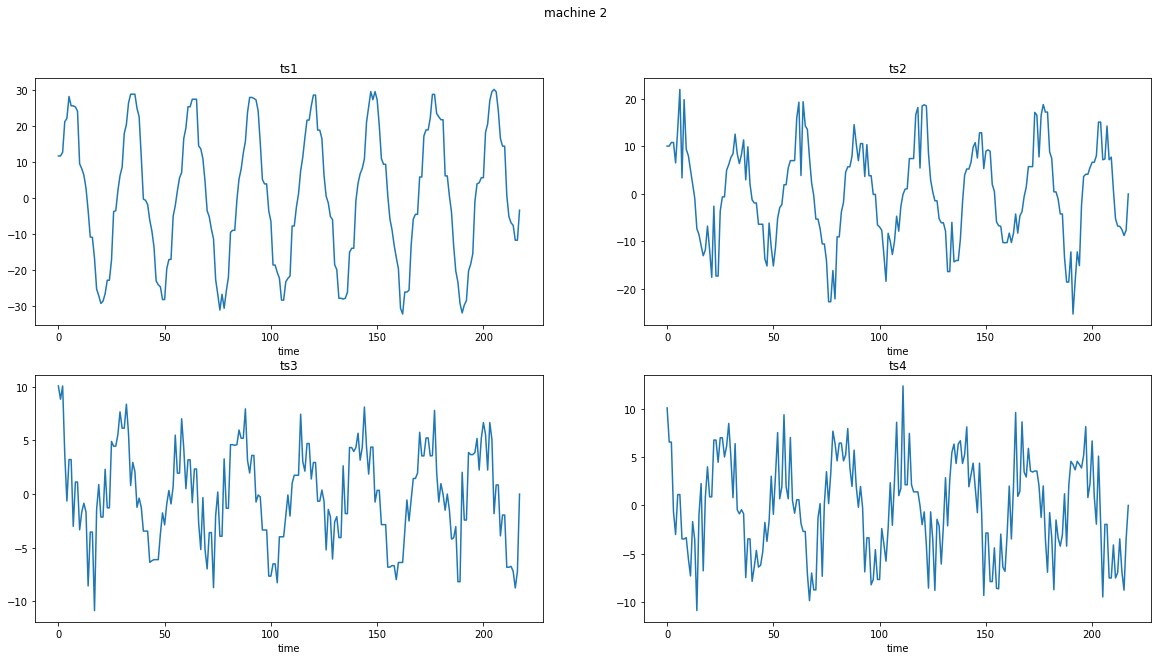

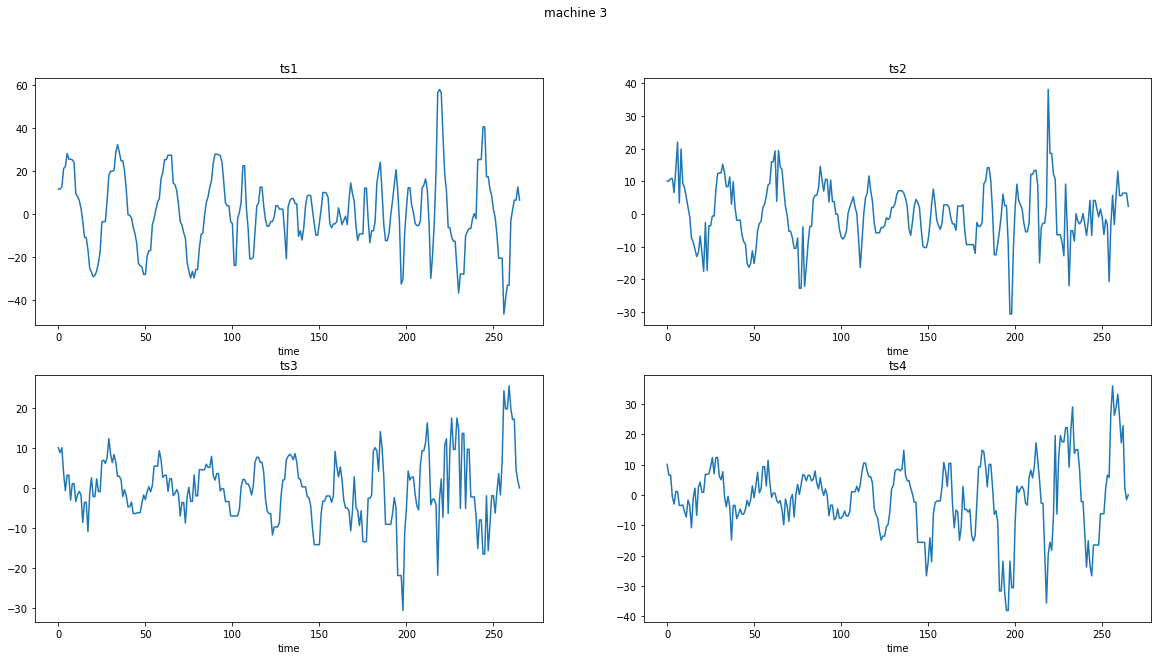

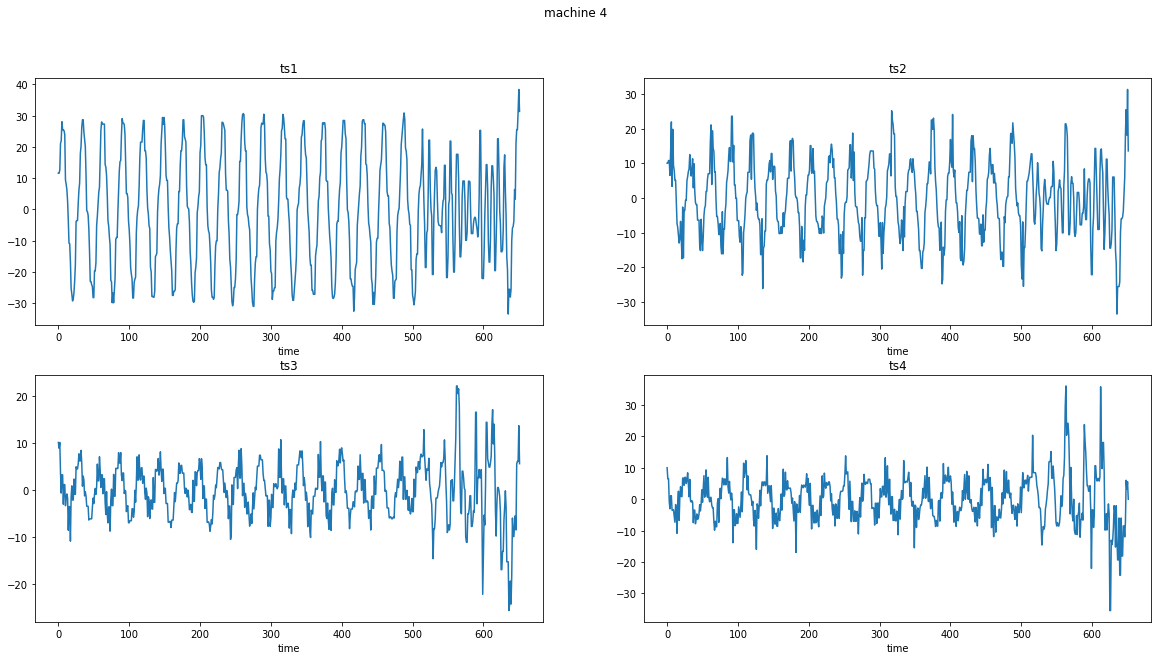

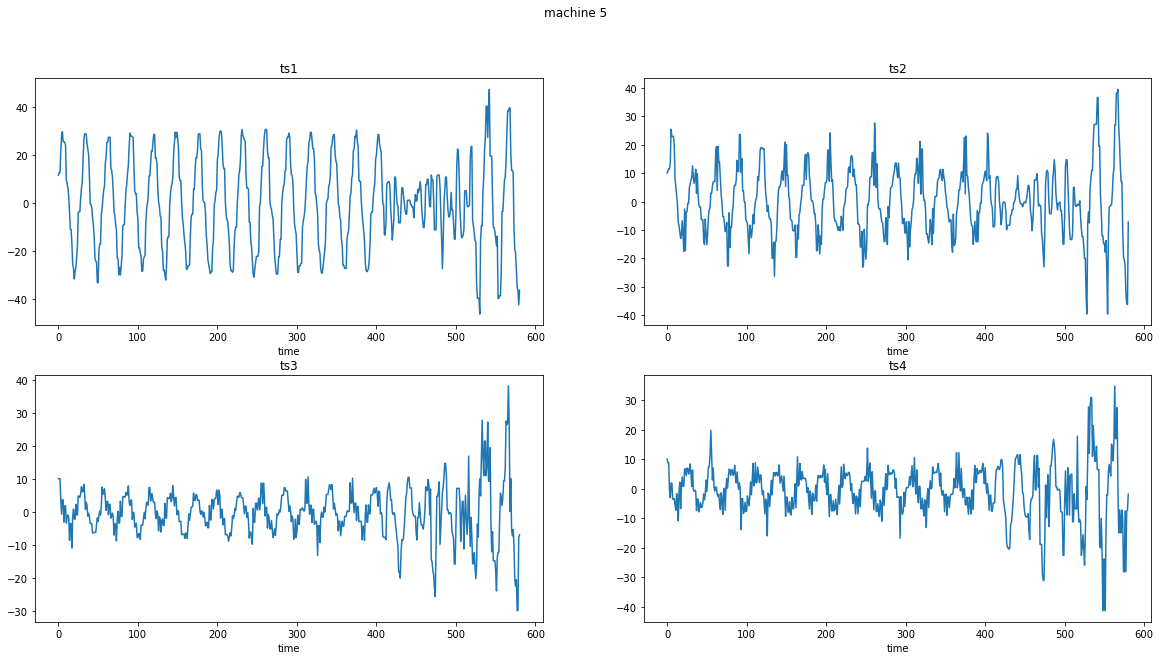

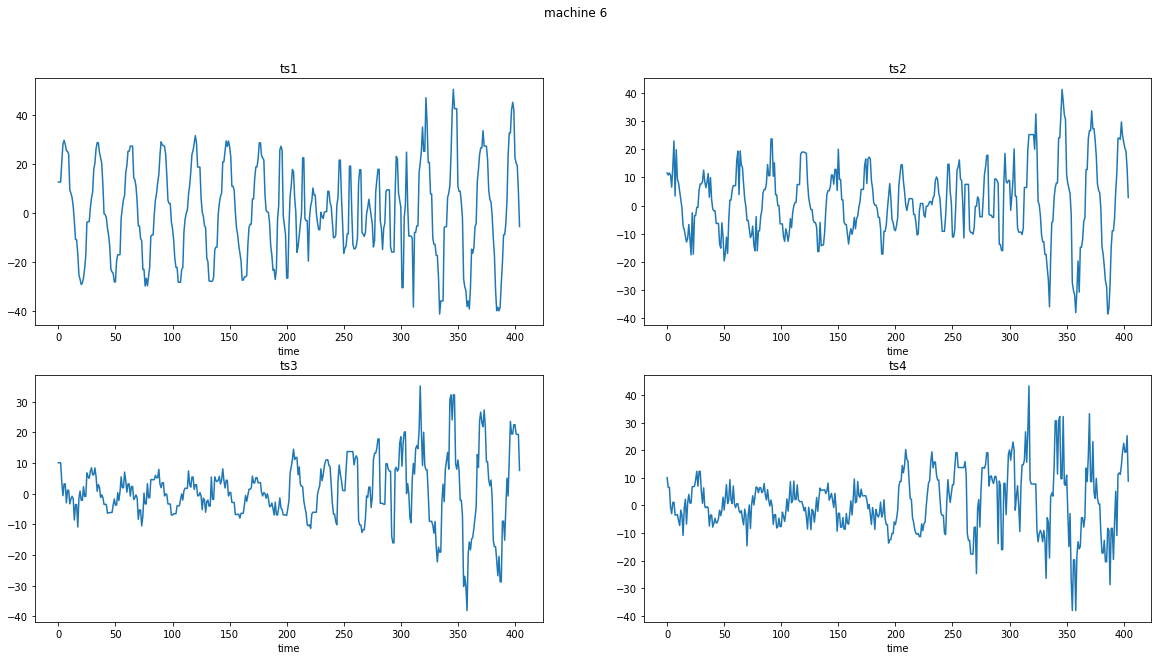

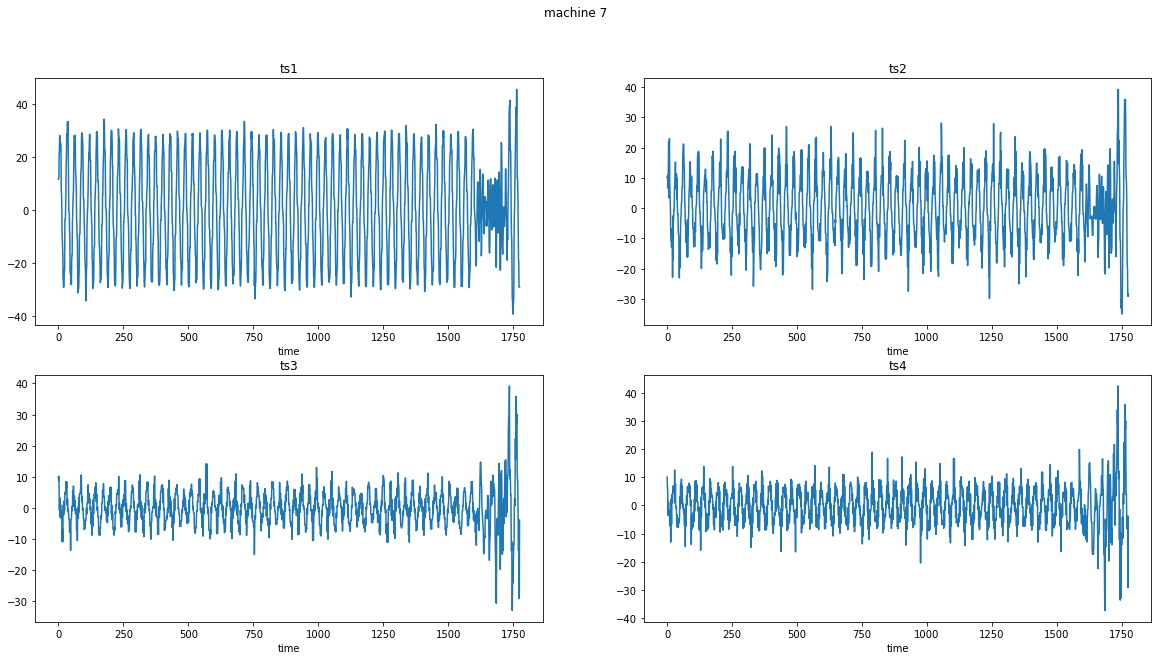

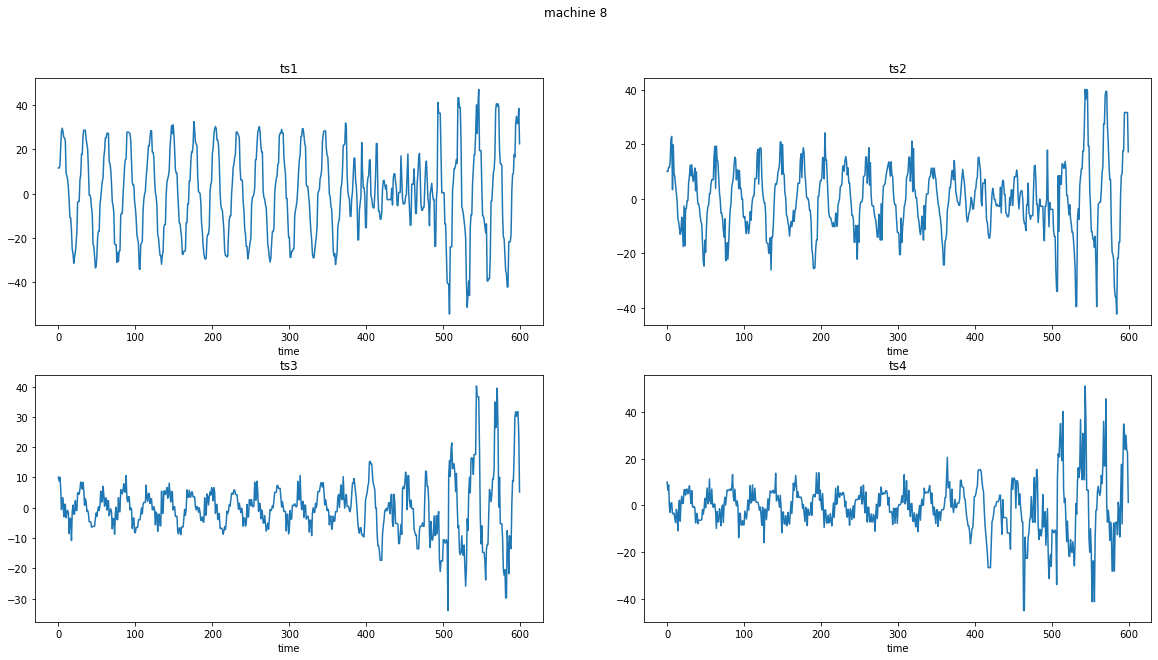

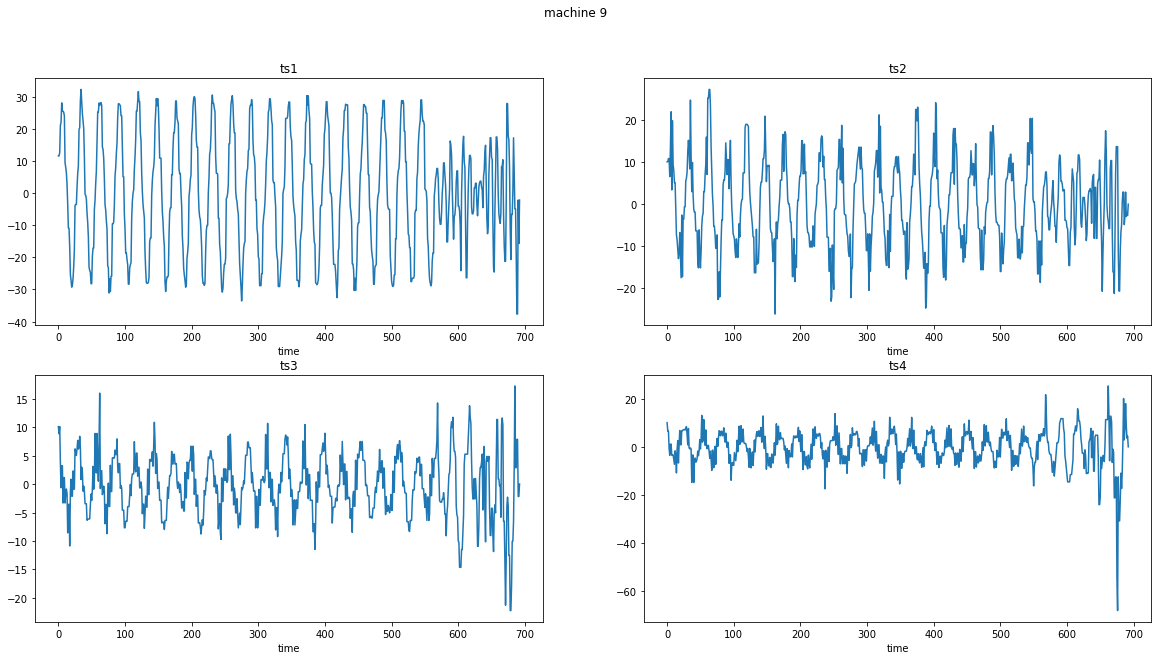

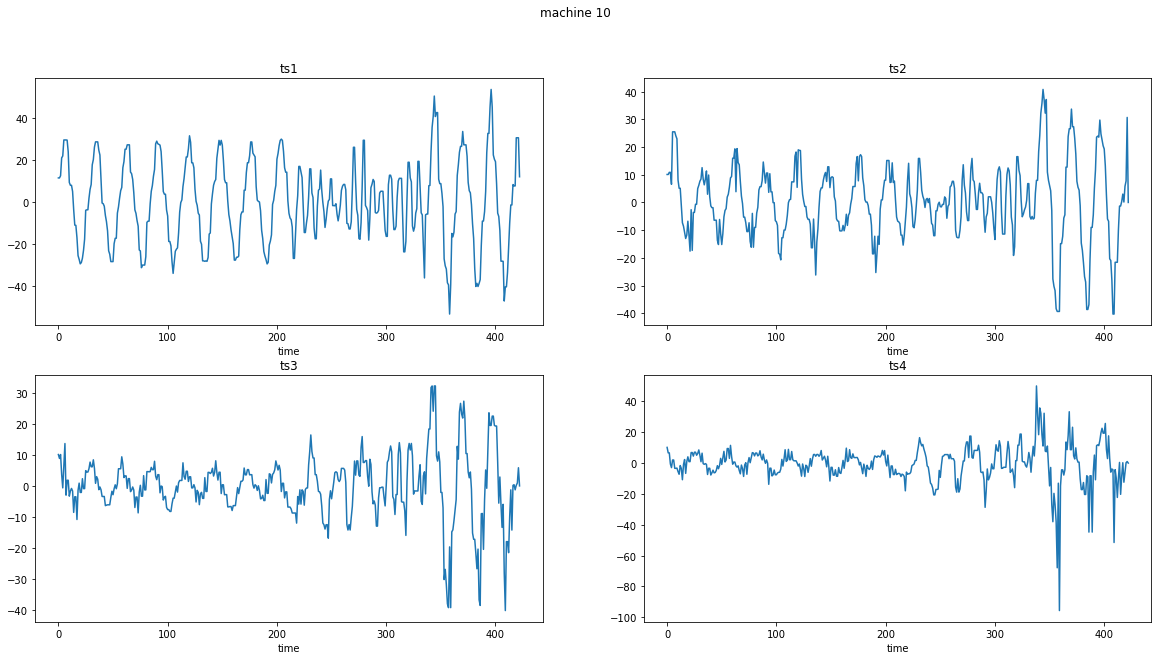

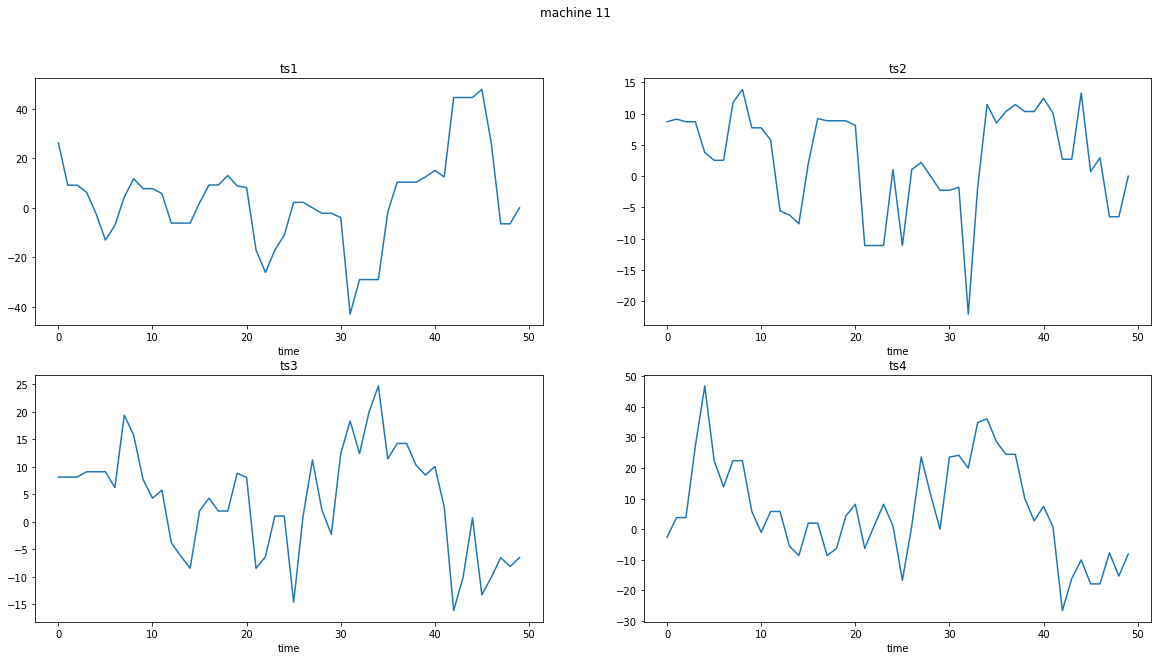

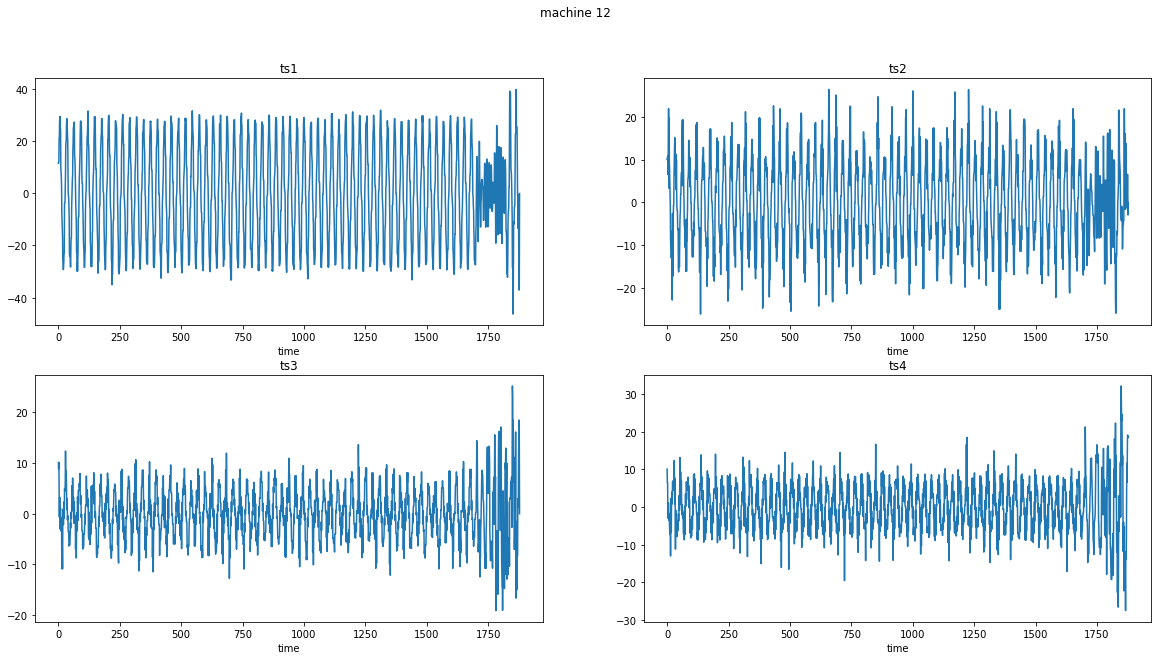

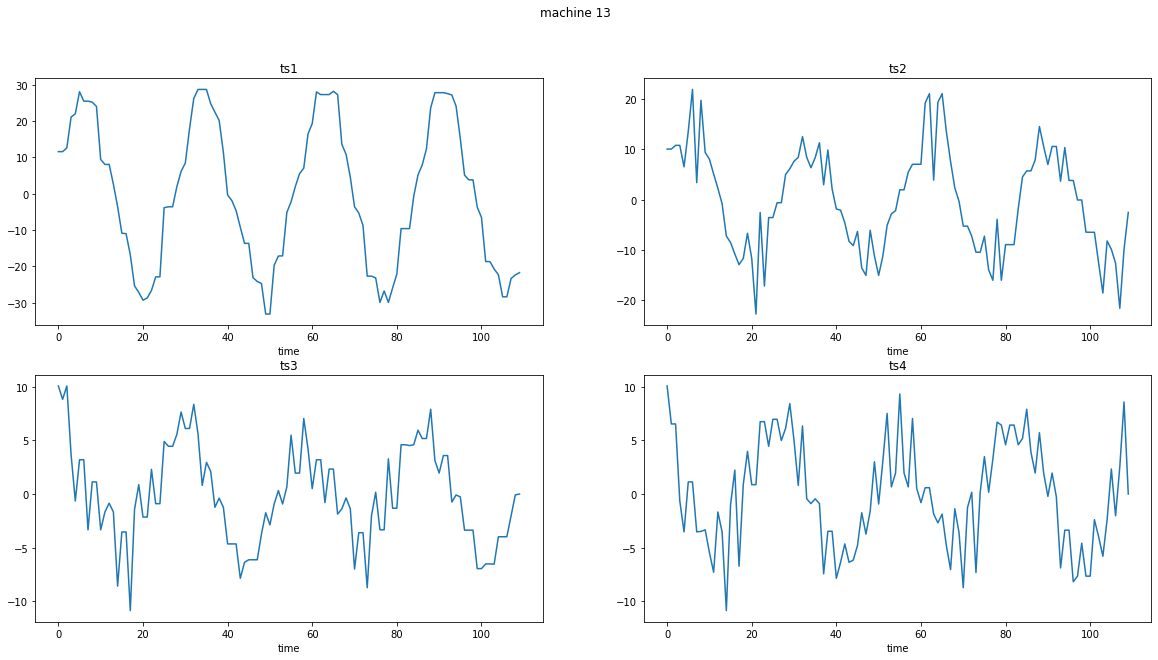

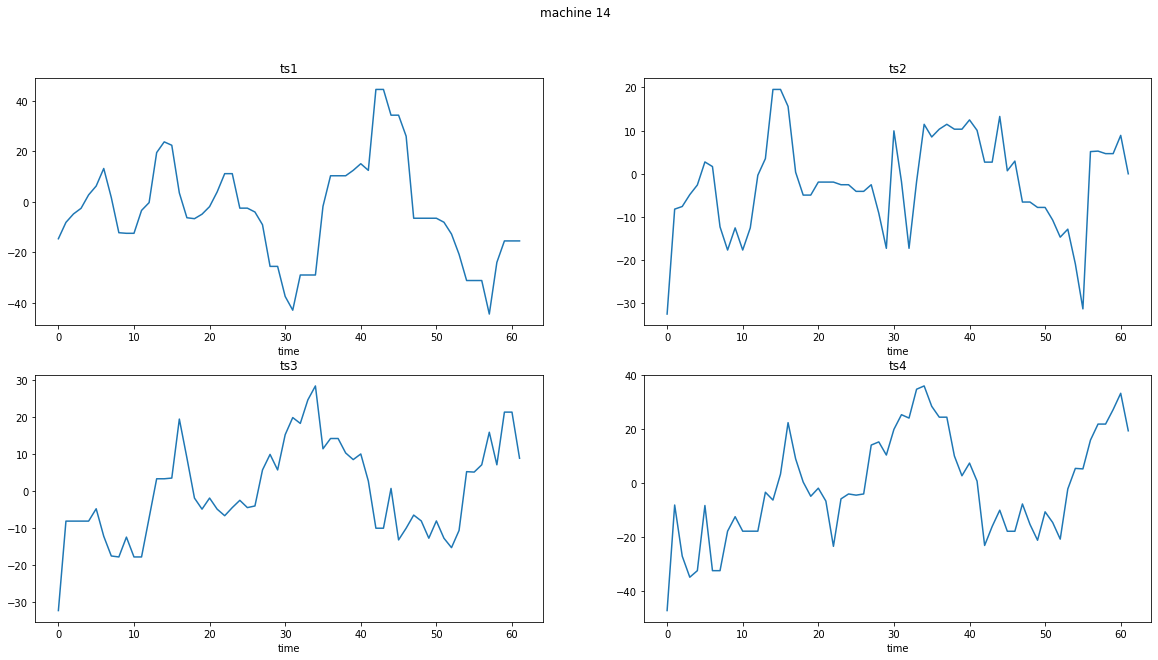

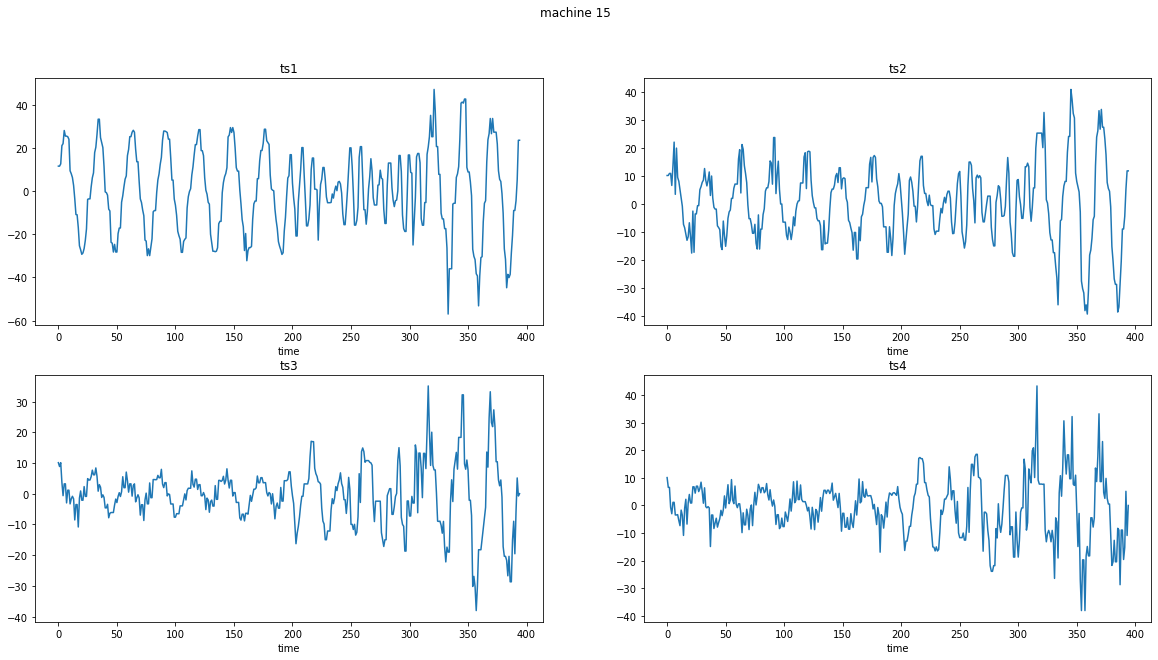

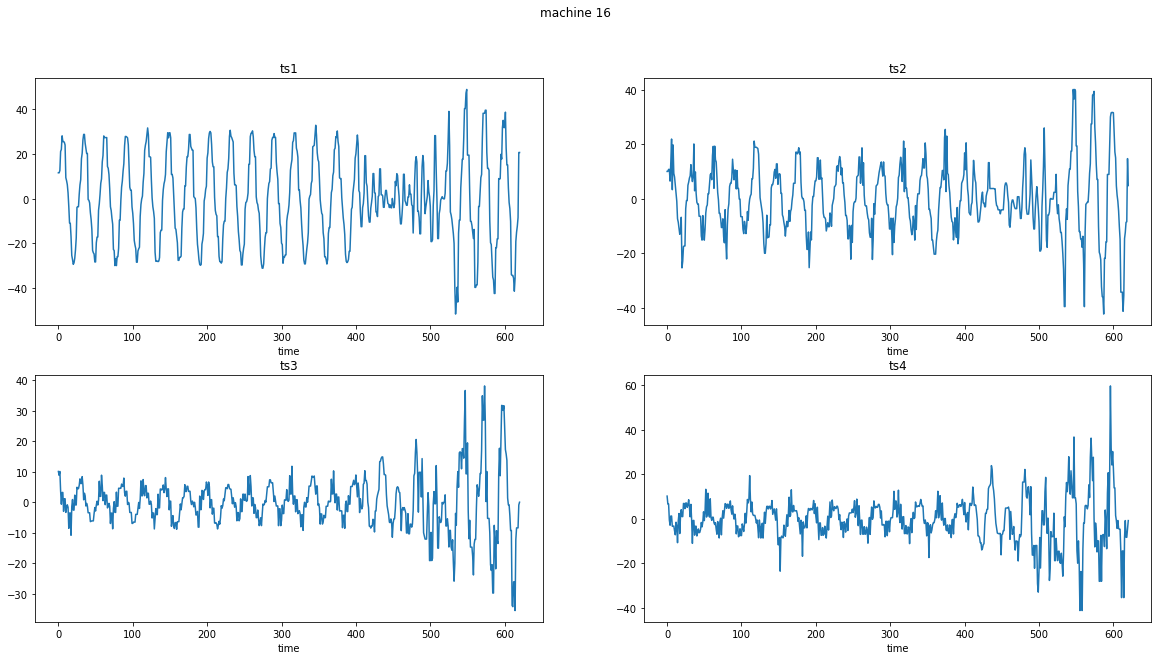

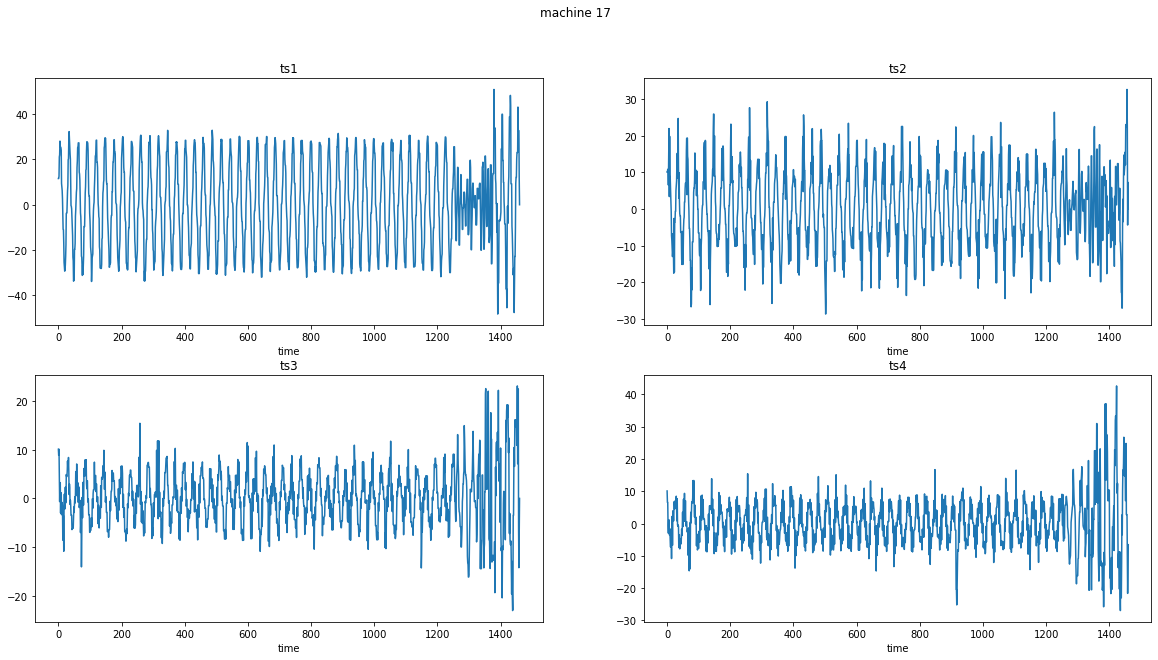

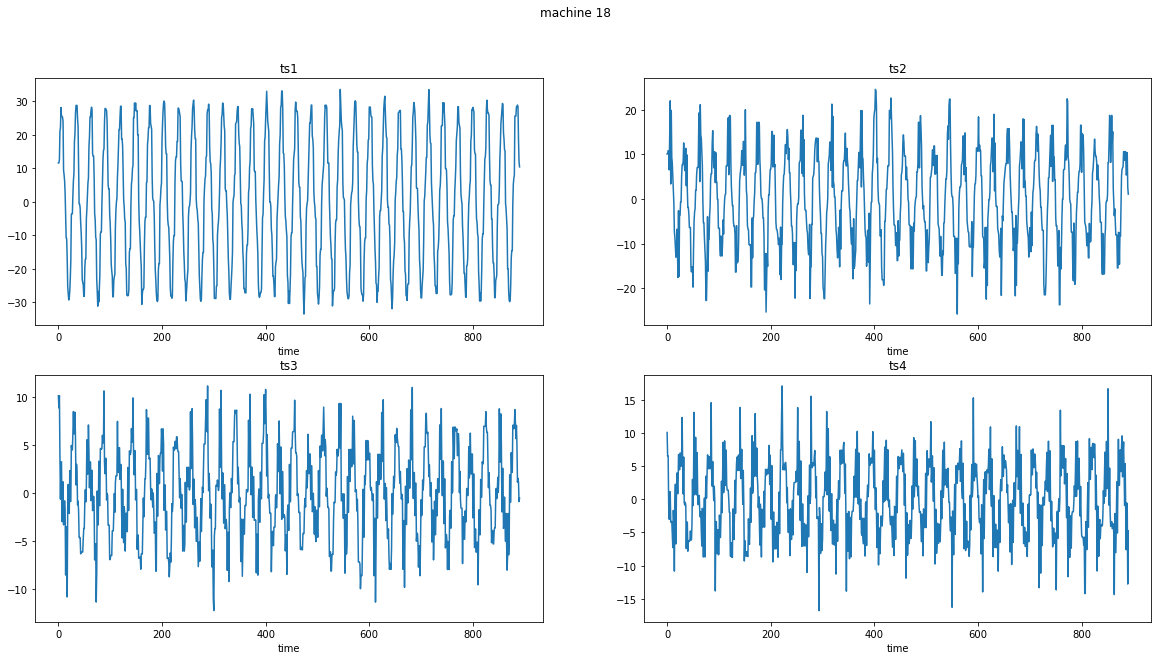

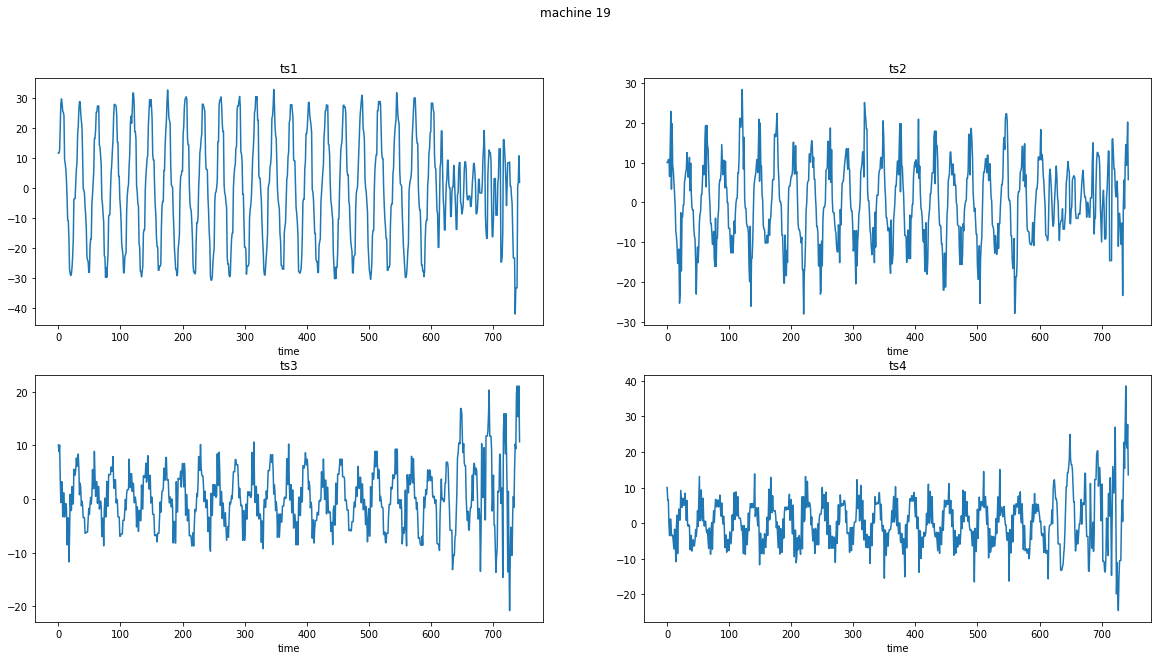

In [28]:
for i, df in enumerate(dfs_denoise):
    fig = plt.figure(figsize=(20,10))
    temp = df.loc[df.apply(lambda x : any(abs(x) > 1), axis = 1), :]
    for j in range(temp.shape[1]):
        plt.subplot(2,2, j+1)
        plt.plot(range(temp.shape[0]), temp.iloc[:, j])
        plt.title(temp.columns[j])
        plt.xlabel('time')
    fig.suptitle('machine ' + str(i))
    plt.show()

The above plots confirmed our initial inspection that the signals follow systematic and periodic patterns when the machines are in their normal states, and once the machines enter the fault states the signals start fluctuating randomly.  

We can now perform spectral analysis to identify discriminatory frequencies that can be used in feature extraction.

## Model Training 

### Strategy Overview: Build A Classifier

- Model Selection: 
I built a Support Vector Machine (SVM) Classifier to identify the modes of the machine using the smoothed signals. SVM Classifier is a powerful machine learning algorithm used in supervised learning. Since the data has no labels, I will need to identify the states of the machine and create the class labels manually. In this way, I can transform this task to a supervised learning problem; however, I may also run on the risk of mislabelling the series which may reduce the accuracy of the model.

  There are two strategies to create class labels: 

    **Normal vs. fault vs. fail**: This leads to a multi-class classification. This is more appropriate if we want to know the exact state of the machine.     
    
    **Normal vs. abnormal**: This leads to a binary classification. If we are not concerned with discerning the fault state or fail state, this would be a better choice. Once an abnormal mode is detected, the machine would be halted.


- Training Data:
I picked the first 10 machines (machine 0 - machine 9) to build the training data. The other 10 machines (machines 10 - 19) were used as testing data to assess the performance of the model. 

  Since we want to identify the faulty state as early as possible, it would be more reasonable to divide the series into segments and use these segments as observations. I chose the window size to be 50, that is, each segment contains 50 measurements from the original series. The choice of the window size was made based on the periodic pattern of the normal mode signals. The signals have a cyclic pattern with a period $\approx 28$. This is also reflected in the spectral analysis. A window width of 50 is long enough to ensure the model to catch this periodic pattern, and it is also short enough so that we can detect the faulty mode as soon as possible.

  Then I performed feature extractions on each segment to build the training data. 


- Model tuning:
A Support Vector Machine Classifier can be trained by tuning the kernel and the penalty factor C coupled with five-fold cross validation. Tuning is an important procedure to obtain an effective model. Cross-validation is used to avoid overfitting.


- Model Validation:
To assess the performance of the model, I performed the classifier on the unseen data (machine 10 - machine 19). The weighted f1 score was the metric used to assess performance during the training process.

### Create Training Data & Class labelling

- Take the observations from machine 0 - machine 9. 
- Take multiple non-overlapping segments with length 50.
- Create a class label for each segment. 
- Concatenate them to prepare for feature extractions.

#### Normal Mode Data

Create data with the 'normal' label; The range below denotes the rows to extract from the data for each machine.

0th machine: 0 - 200  
1st machine: 0 - 800  
2nd machine: 0 - 200  
3rd machine: 0 - 100   
4th machine: 0 - 300     
5th machine: 0 - 300    
6th machine: 0 - 200  
7th machine: 0 - 800  
8th machine: 0 - 350  
9th machine: 0 - 550  

A total of 3800 measurements; 76 segments

In [29]:
# normal states
normal_states = pd.concat([
    dfs_denoise[0].iloc[:200, :], dfs_denoise[1].iloc[:800, :],
    dfs_denoise[2].iloc[:200, :], dfs_denoise[3].iloc[:100, :], 
    dfs_denoise[4].iloc[:300, :], dfs_denoise[5].iloc[:300, :], 
    dfs_denoise[6].iloc[:200, :], dfs_denoise[7].iloc[:800, :],
    dfs_denoise[8].iloc[:350, :], dfs_denoise[9].iloc[:550, :]
], ignore_index = True)
normal_states['state'] = 'normal'
normal_states['id'] = np.repeat(range(76), 50)

#### Faulty Mode Data

Create data with the 'faulty' label; The range below denotes the rows to extract from the data for each machine.

0th machine: 250 - 400   
1st machine: 1600 - 1750   
3rd machine: 100 - 300   
4th machine: 500 - 650     
5th machine: 400 - 600      
6th machine: 200 - 400   
7th machine: 1600 - 1800  
8th machine: 400 - 600   
9th machine: 550 - 700  

A total of 1600 measurements; 32 segments 

In [30]:
# faulty mode
fault_states = pd.concat([
    dfs_denoise[0].iloc[250:400, :], dfs_denoise[1].iloc[1600:1750, :],
    dfs_denoise[3].iloc[100:300, :], dfs_denoise[4].iloc[500:650, :], 
    dfs_denoise[5].iloc[400:600, :], dfs_denoise[6].iloc[200:400, :], 
    dfs_denoise[7].iloc[1600:1800, :], dfs_denoise[8].iloc[400:600, :], dfs_denoise[9].iloc[550:700, :]
], ignore_index = True)
fault_states['state'] = 'faulty'
fault_states['id'] = np.repeat(range(76, 108), 50)

#### Failed Mode Data

Create data with the 'failed' label; The range below denotes the rows to extract from the data for each machine.

0th machine: 500 - 750  
1st machine: 1800 - 2000  
2nd machine: 300 -  550  
3rd machine: 300 -  550  
4th machine: 700 -  950   
5th machine: 600 -  850    
6th machine: 500 -  750    
7th machine: 1800 - 2000   
8th machine: 700 - 1000  
9th machine: 700 - 1000  

A total of 2500 measurements; 50 segments

In [31]:
# failed mode
fail_states = pd.concat([
    dfs_denoise[0].iloc[500:750, :], dfs_denoise[1].iloc[1800:2000, :],
    dfs_denoise[2].iloc[300:550, :], dfs_denoise[3].iloc[300:550, :], 
    dfs_denoise[4].iloc[700:950, :], dfs_denoise[5].iloc[600:850, :], 
    dfs_denoise[6].iloc[500:750, :], dfs_denoise[7].iloc[1800:2000, :],
    dfs_denoise[8].iloc[700:1000, :], dfs_denoise[9].iloc[700:1000, :]
], ignore_index = True)
fail_states['state'] = 'failed'
fail_states['id'] = np.repeat(range(108, 158), 50)

In [32]:
# concatenate them together
df = pd.concat([normal_states, fault_states, fail_states], 
                     ignore_index = True)

### Spectral Analysis

I used Welch's method to estimate the spectral density. This could help us identify discriminatory frequencies, which could be extracted as useful features.

**reference:** [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)

Examining the spectral power density of a normal state example:

top five frequencies for ts 1:  [0.04, 0.02, 0.06, 0.0, 0.1]
top five frequencies for ts 2:  [0.04, 0.02, 0.06, 0.0, 0.44]
top five frequencies for ts 3:  [0.04, 0.02, 0.3, 0.06, 0.32]
top five frequencies for ts 4:  [0.04, 0.02, 0.3, 0.06, 0.32]


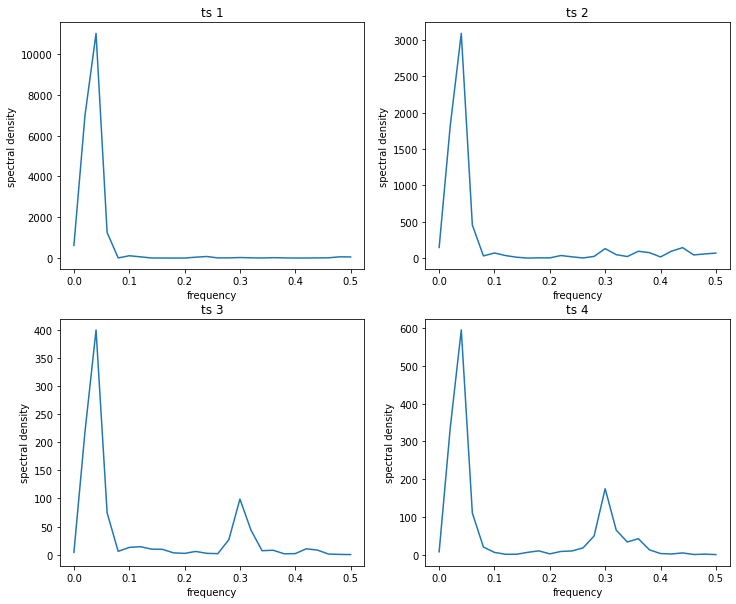

In [34]:
# spectral power density for one normal state example
fig = plt.figure(figsize=(12, 8))
for j in range(4):
    f, Pxx = signal.welch(df[df['id'] == 1].iloc[:, j], nperseg = 50)
    plt.subplot(2,2,j+1)
    plt.plot(f, Pxx)
    plt.title('ts ' + str(j+1) )
    plt.xlabel('frequency')
    plt.ylabel('spectral density')
    print("top five frequencies for ts {}: ".format(str(j+1)), [f[i] for i in np.argsort(-Pxx)[:5]])
plt.show()

The periodograms show peaks at frequencies 0.04 for ts1 and ts2, and show peaks at 0.04 and 0.3 for ts3 and ts4. Average all the data from normal state and check if this observation holds in general.

top five frequencies for ts 1:  [0.04, 0.02, 0.06, 0.0, 0.1]
top five frequencies for ts 2:  [0.04, 0.02, 0.06, 0.0, 0.3]
top five frequencies for ts 3:  [0.04, 0.02, 0.3, 0.06, 0.32]
top five frequencies for ts 4:  [0.04, 0.02, 0.3, 0.06, 0.32]


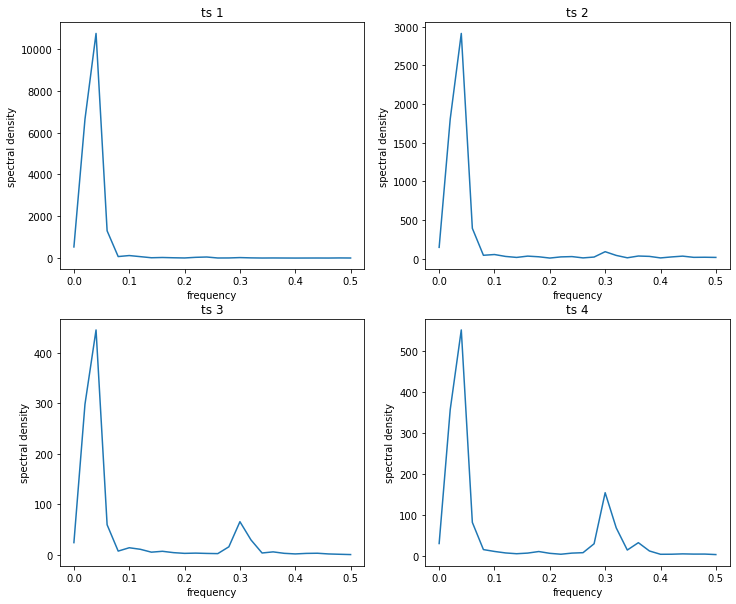

In [35]:
# check the estimated power spectral density for all the normal state data.
fig = plt.figure(figsize=(12, 10))
for j in range(4):
    f, Pxx = signal.welch(df[df['state'] == 'normal'].iloc[:, j], nperseg = 50)
    plt.subplot(2,2,j+1)
    plt.plot(f, Pxx)
    plt.xlabel('frequency')
    plt.ylabel('spectral density')
    plt.title('ts ' + str(j+1) )
    print("top five frequencies for ts {}: ".format(str(j+1)), [f[i] for i in np.argsort(-Pxx)[:5]])
plt.show()

It seems that our observations are general for the normal state signals. Now we look at the periodograms of some fault state examples:

top five frequencies for ts 1:  [0.06, 0.1, 0.12, 0.04, 0.08]
top five frequencies for ts 2:  [0.12, 0.06, 0.08, 0.1, 0.02]
top five frequencies for ts 3:  [0.02, 0.08, 0.04, 0.06, 0.12]
top five frequencies for ts 4:  [0.02, 0.04, 0.26, 0.0, 0.06]


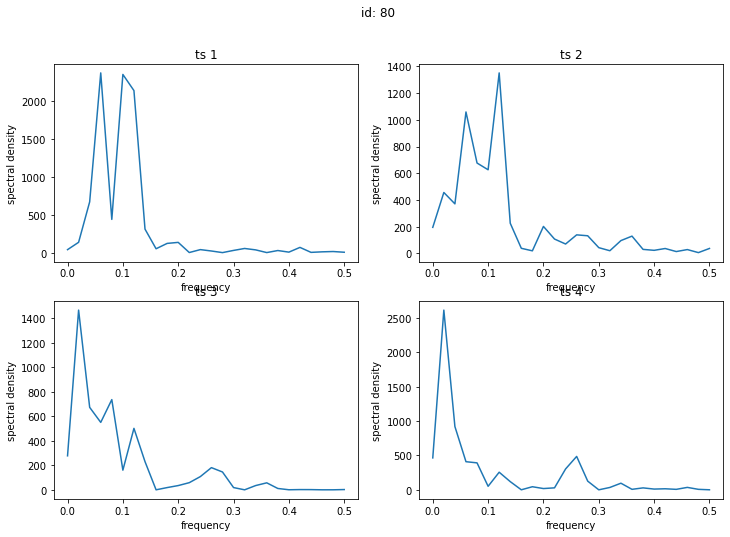

top five frequencies for ts 1:  [0.12, 0.14, 0.1, 0.08, 0.06]
top five frequencies for ts 2:  [0.06, 0.12, 0.04, 0.08, 0.14]
top five frequencies for ts 3:  [0.04, 0.06, 0.08, 0.02, 0.12]
top five frequencies for ts 4:  [0.04, 0.06, 0.02, 0.26, 0.08]


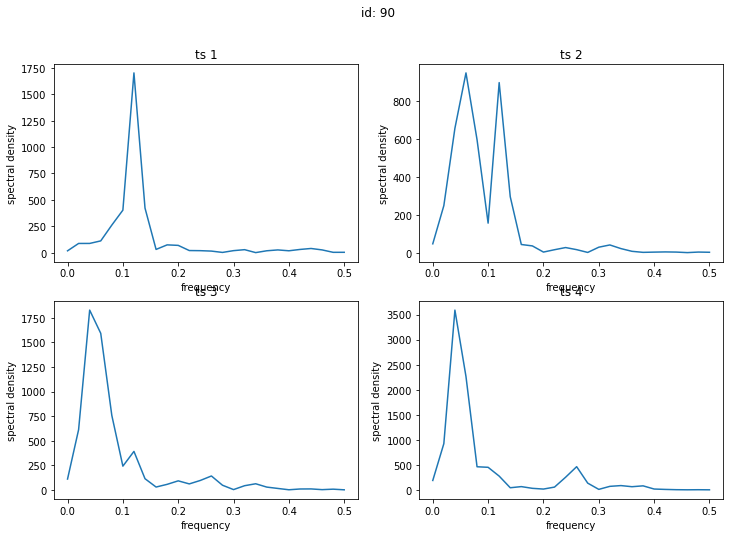

top five frequencies for ts 1:  [0.04, 0.06, 0.02, 0.08, 0.14]
top five frequencies for ts 2:  [0.04, 0.06, 0.02, 0.08, 0.12]
top five frequencies for ts 3:  [0.04, 0.06, 0.02, 0.08, 0.3]
top five frequencies for ts 4:  [0.04, 0.06, 0.02, 0.08, 0.3]


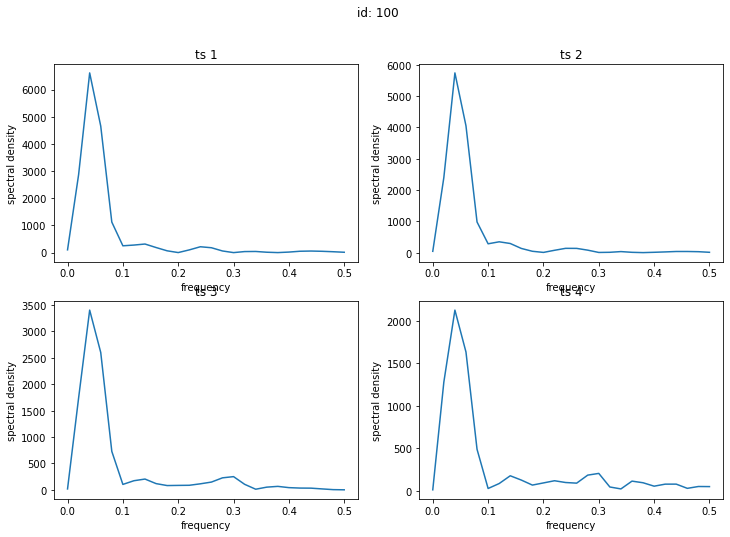

In [36]:
# observe the periodograms for some fault state data
for id_no in [80, 90, 100]:
    fig = plt.figure(figsize=(12, 10))
    for j in range(4):
        f, Pxx = signal.welch(df[df['id'] == id_no].iloc[:, j], nperseg = 50)
        plt.subplot(2,2,j+1)
        plt.plot(f, Pxx)
        plt.xlabel('frequency')
        plt.ylabel('spectral density')
        plt.title('ts ' + str(j+1) )
        print("top five frequencies for ts {}: ".format(str(j+1)), [f[i] for i in np.argsort(-Pxx)[:5]])
    fig.suptitle('id: ' + str(id_no))
    plt.show()

The periodograms of the faulty mode data do not show consistent patterns. However, they do have different power density values at the peak frequencies of the normal state data. Thus, we can use the spectral densities at the frequencies proposed above as features to classify the mode of the time series segments.  

To recap, I will extract the estimated power densities at the following frequencies as features:
- ts1: freq = 0.04
-  ts2: freq = 0.04
-  ts3: freq = 0.04, 0.3
-  ts4: freq = 0.04, 0.3  

Some other useful features to be included are:
- range: maximum - minimum
- max/min ratio  
- standard deviation

### Feature Extraction

In [37]:
# Functions to help to extract features

def spectral_density(ts, freqs):
    '''
    Return the spectral density corresponding to the giving frequencies.
    '''
    f, Pxx = signal.welch(ts, nperseg = len(ts))
    dens = []
    for freq in freqs:
        ind = np.where(f == freq)
        dens += [Pxx[ind][0]]
    return dens

def get_density(ts):
    '''
    Extract the spectral power densities
    '''
    freq_to_extract = {'ts1':[0.04], 'ts2':[0.04], 'ts3':[0.04, 0.3], 'ts4':[0.04, 0.3]}
    den_extracted = []
    for s, f in freq_to_extract.items():
        den_extracted += spectral_density(ts[s], f)
    return den_extracted

def get_features(ts):
    '''
    Extract the other needed features
    '''
    features = []
    for x in ['ts1', 'ts2', 'ts3', 'ts4']:
        features += [max(ts[x]) - min(ts[x]), max(ts[x]) / min(ts[x]), np.std(ts[x])]
    return features

In [38]:
def feature_extraction(df):
    '''
    For the given dataframe, extract the features and return them in the form of a dataframe.
    '''
    
    freq_dat = pd.DataFrame(df.groupby('id').apply(get_density).to_list(), 
            columns = ['ts1_freq', 'ts2_freq', 'ts3_freq_1','ts3_freq_2', 'ts4_freq_1','ts4_freq_2'])
    
    other_dat = pd.DataFrame(df.groupby('id').apply(get_features).to_list(), 
                 columns = ['ts1_range', 'ts1_range_ratio', 'ts1_std',
                            'ts2_range', 'ts2_range_ratio', 'ts2_std',
                            'ts3_range', 'ts3_range_ratio', 'ts3_std',
                            'ts4_range', 'ts4_range_ratio', 'ts4_std'])
    
    return pd.merge(freq_dat, other_dat, left_index = True, right_index = True)

### Training Data

Now we are going to create the training data that can be fed directly to the SVM model.

In [39]:
# extract the features and store them in the dataframe `X_train`
# extract the machine modes as class labels and store them in y_train
X_train = feature_extraction(df)
y_train = df.groupby('id').head(1)['state'].reset_index(drop = True)

In [40]:
X_train.head(5)

ts1_freq     ts2_freq  ts3_freq_1  ts3_freq_2  ts4_freq_1  ts4_freq_2  \
0  11639.311723  2345.671909  494.071296   93.626559  665.904351  191.180431   
1  11003.679874  3086.922778  400.337007   98.972542  595.598483  174.617040   
2  11186.621805  2993.545010  282.018984   85.457909  749.540332  242.141140   
3  11217.258118  2609.537293  361.226017   25.015805  483.135054  130.605395   
4  10620.690385  2237.255310  469.738706   90.050003  563.919886  139.328606   

   ts1_range  ts1_range_ratio    ts1_std  ts2_range  ts2_range_ratio  \
0  61.829937        -0.867493  19.472373  39.528351        -1.253148   
1  58.456827        -0.907248  18.309741  42.097229        -0.856518   
2  59.954039        -1.113724  19.583827  35.315561        -1.160938   
3  59.293460        -0.936017  18.299893  37.547149        -0.847866   
4  58.910249        -1.011935  19.249312  45.624978        -1.599561   

     ts2_std  ts3_range  ts3_range_ratio   ts3_std  ts4_range  \
0   9.763871  20.947562        -0.928234  4.929562  30.227010   
1   9.737592  16.660488        -0.907710  3.884364  23.983608   
2  10.015483  15.050720        -1.163719  4.005504  30.948691   
3   9.440619  13.861538        -0.742028  3.913373  21.654625   
4  11.159068  20.951296        -0.927763  4.964382  20.951296   

   ts4_range_ratio   ts4_std  
0        -0.691458  5.696831  
1        -0.637910  5.343344  
2        -0.663524  5.720081  
3        -1.485142  5.000193  
4        -0.927763  5.181938

In [41]:
y_train.head(5)

0    normal
1    normal
2    normal
3    normal
4    normal
Name: state, dtype: object

In [42]:
# shuffle the rows of X_train and y_train; store them in X and y; Shuffling needs to be consistent between X and y.
temp = pd.merge(X_train,pd.DataFrame(y_train), left_index = True, right_index = True).sample(frac = 1, random_state = 1)
X = temp.iloc[:, :-1]
y = temp.iloc[:, -1]

### Model Training

A SVM classifier is trained for this task. As the prompt directed me to pinpoint both the faulty mode and the failed mode, I perform a multi-class classification with the 'one-vs-res' technique. However, if we are only to terminate the machine once we detect the faulty mode. It may be more natural to convert this to a binary classification with labels 'normal' and 'abnormal', where faulty mode and failed mode are combined to one class. 

The model is tuned with 5-fold cross validation and the metric used was a weighted F1-score to handle the imbalanced distribution of the class labels.  

Note that feature normalization is necessary for SVM classifiers. I achieved this by using the sklearn method `StandardScaler`. This scaler can be fitted with the training data and then can be used to transform the testing data. This ensures that the testing data is going through the same transformation as the training data.

**Reference:**  
[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)  
[sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler)

In [43]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [44]:
# normalization 
col_names = X.columns
transformer = StandardScaler()
X = pd.DataFrame(transformer.fit_transform(X), columns = col_names)

In [45]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[ 0.1, 0.5, 1, 2, 5, 10 ]}
clf = GridSearchCV(estimator = svm.SVC(decision_function_shape='ovr'), param_grid = parameters, scoring = 'f1_weighted')
clf.fit(X, y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 2, 5, 10],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             scoring='f1_weighted')

In [46]:
# show the best model parameters
clf.best_params_

{'C': 0.1, 'kernel': 'linear'}

In [47]:
# show the best score
clf.best_score_

1.0

The best model parameters are chosen to be: C = 0.1 and kernel = linear. The best score is 1.0, which means the model fits the training data with high cross validation score. Then we will see how the model performs on the data which it has not seen. 

### Model Validation

The model is then applied to data from Machines 10 - 19, which contain the signals that the model has not seen. The result will be shown in a graphical form instead of using numeric metrics, as numeric metrics require class labels for each window, which is time consuming and error prone (due to human error). Visualizing the predicted results could assess the model performance effectively.

In [48]:
def visualize_class(res, title, machine_id):
    '''
    Plot the time series and color the classified regions.
    '''
    normal_ind = np.where(res == 'normal')[0]
    fault_ind = np.where(res == 'faulty')[0]
    fail_ind = np.where(res == 'failed')[0]
    
    
    regions = [Line2D([0], [0], color = 'green', lw=4, alpha=0.2),
                    Line2D([0], [0], color= 'red', lw=4,alpha=0.2),
                    Line2D([0], [0], color= 'grey', lw=4, alpha = 0.2)]
    
    fig, ax =  plt.subplots(figsize=(15,6))
    ax.plot(range(3000), dfs_denoise[machine_id].iloc[:,:4])
    for k in normal_ind:
        ax.axvspan(k*50, (k+1)*50, alpha=0.2, edgecolor = None, facecolor='green')
    for k in fault_ind:
        ax.axvspan(k*50, (k+1)*50, alpha=0.2, edgecolor = None, facecolor='red')
    for k in fail_ind:
        ax.axvspan(k*50, (k+1)*50, alpha=0.2, edgecolor = None, facecolor='grey')
    ax.legend(regions, ['Normal', 'Faulty', 'Failed'])
    plt.title(title)
    plt.xlabel('time')
    plt.show()

In [49]:
def classify_state(machine_id):
    # extract the dataframe and create segment ids
    df = dfs_denoise[machine_id]
    col_nams = df.columns
    df['id'] = np.repeat(range(60),50)
    
    # extract the needed features
    df = feature_extraction(df)
    # transform the testing data the same way as we transform the training data
    df = pd.DataFrame(transformer.transform(df),columns = col_names)
    res = clf.predict(df)
    visualize_class(res, 'machine {}'.format(machine_id), machine_id)

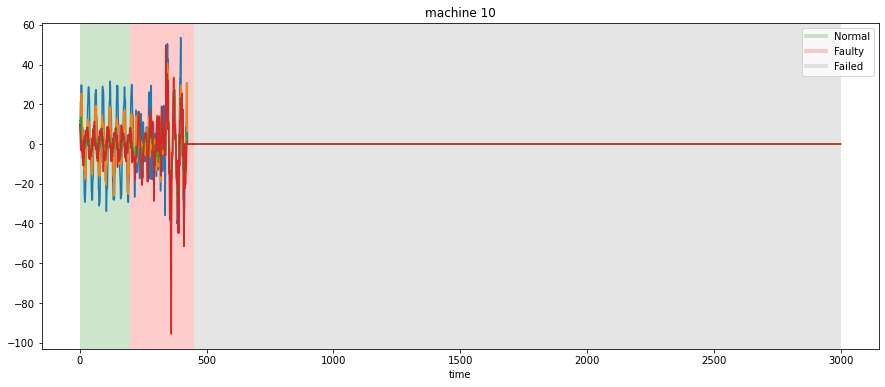

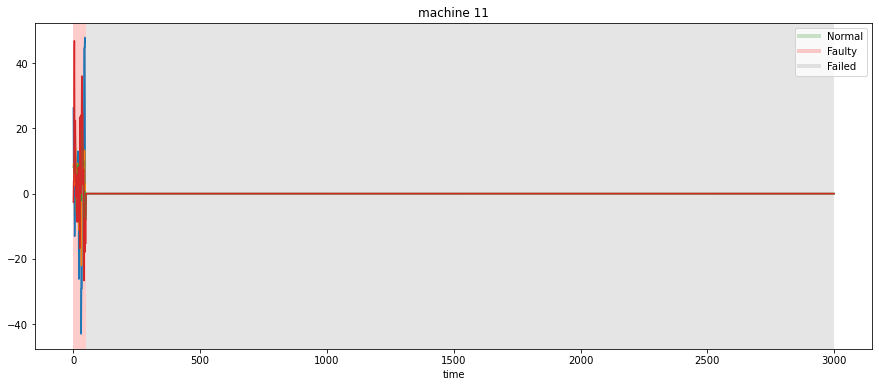

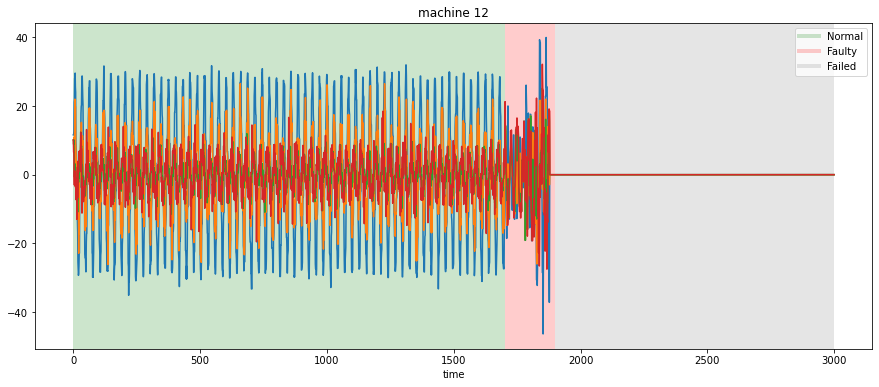

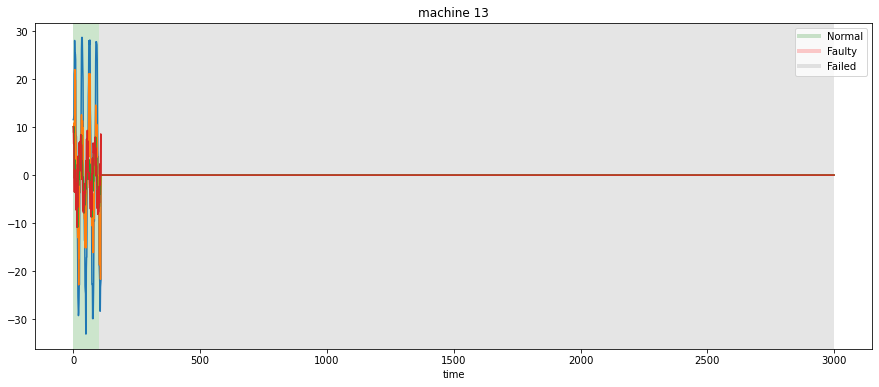

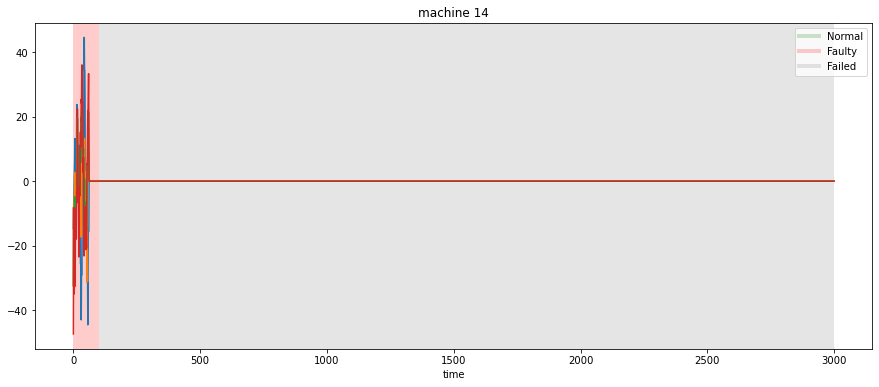

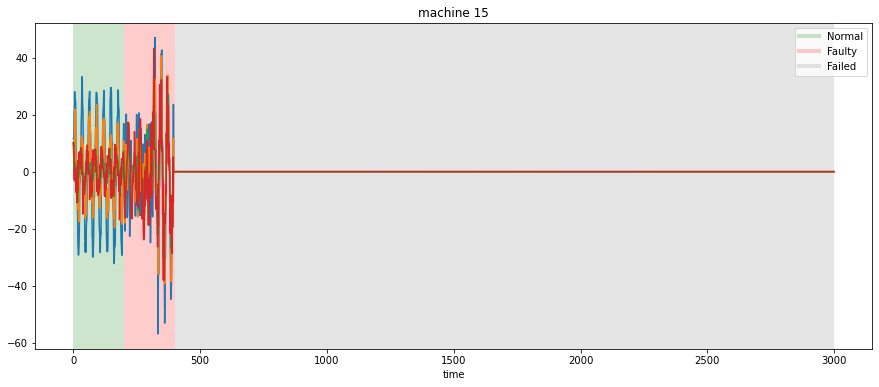

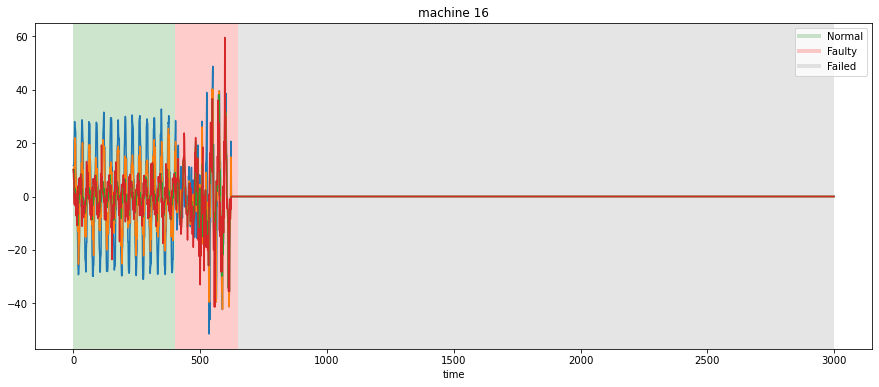

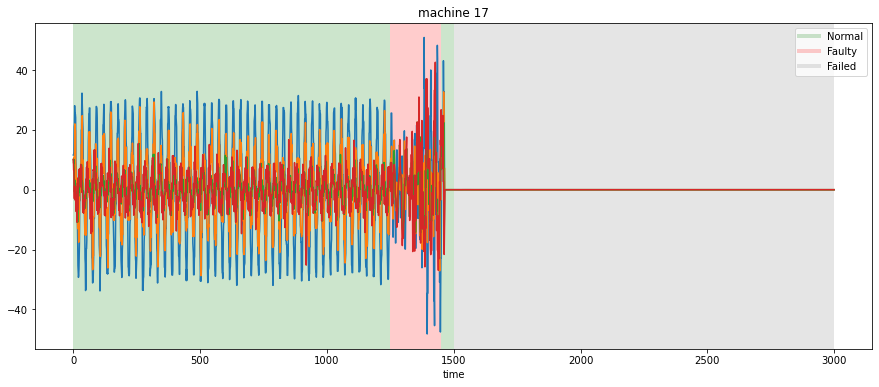

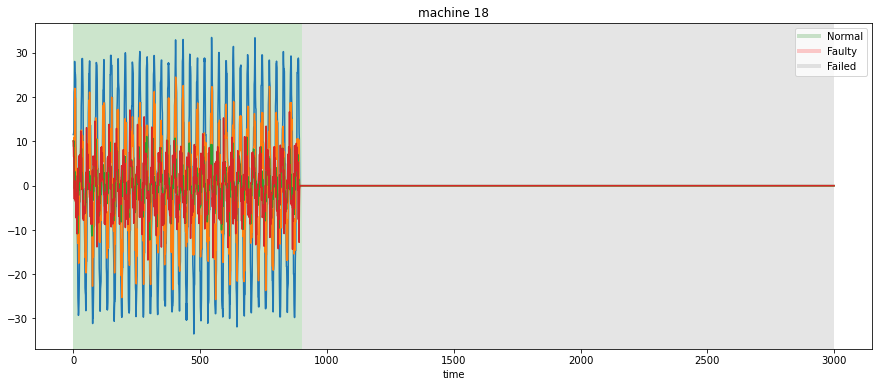

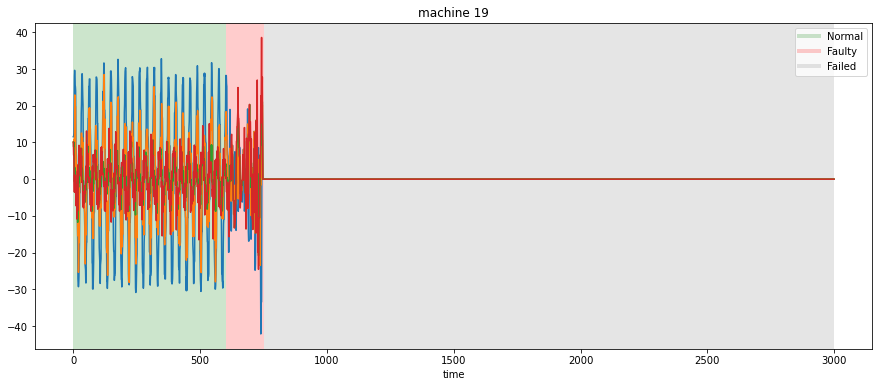

In [50]:
for machine_id in range(10, 20):
    classify_state(machine_id)

The plots above show the classification results generated by the model applied to the testing data. The color of the shaded region represents the class to which the classifier assigned the data. A green shade denotes a normal mode; a red shade denotes a faulty mode; a grey shade denotes a failed mode. Based on the plots above, the model performs well on identifying the unseen signals. For machine 17, there is a small region in faulty mode get misclassified to a normal mode. However, since the previous faulty mode is detected correctly, this likely would not generate issues if the machine is stopped once the faulty mode is detected.

## Discussion

To recap, I trained an SVM Classifier combined with appropriate feature extraction to solve this fault detection task. The feature extractions were mainly established on the observations from data visualization and the spectral analysis. The window size was chosen carefully to capture the periodic pattern of the signals and to detect the faulty mode promptly. Based on the testing result, the performance of the classifier is satisfactory. It can detect the faulty mode reasonably accurate and fast.  

The fact that the data from normal mode has very consistent patterns simplified the classification tasks. More features may need to be extracted if there are some variations of the patterns among the machines. The effectiveness of the model is tied with the correctness of the manual labelling. This step was quite time consuming and may not be appropriate if we need to generate a large training set. 

The task could also be converted into a binary classification problem, which could slightly reduce the amount of work in the labelling procedure. This may also improve the accuracy of the model. It is easier for the model to classify if the mode is normal or not rather than classifying the data into the faulty mode. The faulty modes have inconsistent patterns which may be hard to learn. 

### Other Attempts:

Besides the strategy described here, I also attempted two other approaches. Though they did not work well, I would like to give them some honorable mentions. 

- Polynomial Fitting + DTW Disparity Measure  

  Once I noticed that there is a very consistent pattern in the normal mode signals, I thought I could fit the repeated curve with a polynomial and generate a time series data as if there's no faulty state or failed state. Then I split the observed series into small segments and compared them to the generated 'normal' series. The disparity measure I used was dynamic time warping (DTW). If the disparity is large, then the machine has likely entered a faulty or failed state. This method worked well on series produced by machines that entered the faulty state sooner but performed poorly on the other series. By visualizing the generated data and the real data I found that there was a phase shift, and this shift became more severe as time increased. This was likely caused by the non-exact period estimation.  
  

- Spectral Density Estimation + Hypothesis Testing  

  The approach was adapted from the paper *Time-series methods for fault detection and identification in vibrating structures* (Fassois et.al, 2007). This method leverages the difference in spectral density of the signals to differentiate the signals from different classes. Firstly, I estimated the spectral density using Welch's method and then calculated the ratio of the observed spectral density and the hypothesized spectral density. Under the null hypothesis that the two series have the same structures, the ratio follows an F-distribution. We then can make the classification decision based on the p-value of the test statistics. This method did not perform well. This could be because the number of measurements were too few. This may have caused the degree of freedom of the numerator to be much smaller than that of the denominator. As a result, it was difficult to reject the test. 
  
**Reference:**  
Fassois Spilios D and Sakellariou John S 2007, Time-series methods for fault detection and identification in vibrating structures.  
*Phil. Trans. R. Soc. A.365411–448.* http://doi.org/10.1098/rsta.2006.1929